# Graph Sampling

This notebook presents an implementation of all the methods described in the paper [A Survey and Taxonomy of Graph Sampling](https://arxiv.org/abs/1308.5865).


## Basic useful definitions

A graph $G=(V,E)$ is a pair of $n$ nodes $u \in V$ and a set of unordered pairs of $m$ edges $e_{uv} = (u,v) \in E$. Without any loss of generality we will consider here only cases of undirected and unweighted $G$ graphs. These are simply a special case of graphs where all weights are unitary and for every edge $(u,v)$ there is also the opposite $(v,u)$.

Some notations:
- $\mathcal{N}(u)=\{v \in V \::\: (u,v)\in E \}$ is the **neighborhood** of a node and specifically the set of nodes connected to him. In the case of undirected graphs, closeness is a symmetric property: $v \in \mathcal{N}(u)\implies u \in \mathcal{N}(v)$;
- $\delta(u) = \{e_{uv} \in E \: :\: v \in \mathcal{N}(u)\}$ is the set of edges incident to a node and therefore which connect to a neighbor;
- $d_G(u) = |\mathcal{N}(u)| = |\delta(u)|$ is the **degree** of a node which indicates the number of edges incident to it or the number of neighbors;
- Given a subset of nodes $S \subset V$ are respectively indicated as:
 - $G_S = (V_S, E_S)$ the **induced graph** by $S$, where $V_S = S$ and $E_S = \{(u_S, v_S) \: : \: u_s \in V_S, v_s \in V_s, v_s \in \mathcal{N}(u_s)\}$. A **sampled graph** will look like this and have $n_S = |V_S|$ nodes and $m_S = |E_S|$ edges.


## Dataset

The dataset on which the sampling algorithms will be tested will be presented below.

In [2]:
import os
import torch
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from IPython.display import display, HTML
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx, to_dense_adj, subgraph, coalesce, to_undirected, k_hop_subgraph, remove_self_loops, degree, sort_edge_index
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

### Cora Dataset

The dataset contains a single graph $G$ made up of:
- $|V|=2708$ nodes each representing a different scientific publication to which a label relating to the topic and a numerical vector describing its content has been associated;
- $|E|=10556$ edges connecting two articles if there is a citation between them

In [3]:
dataset = Planetoid("Datasets", "Cora")
dataset._data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Let's visualize some properties of the dataset that we would like to maintain once the sampling has been done.



In [4]:
def graph_info(graph):
  net = to_networkx(graph, to_undirected=True)
  print(f'Number of nodes: {graph.num_nodes}')
  print(f'Number of edges: {graph.num_edges}')
  print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
  print(f'Has self-loops: {graph.has_self_loops()}')
  print(f'Is undirected: {graph.is_undirected()}')
  print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
  print(f'Number of classes: {dataset.num_classes}')
  print(f'Number of connected components: {nx.number_connected_components(net)}')
  print(f'Average clustering coefficient: {nx.average_clustering(net):.5f}')
  print(f'Density: {nx.density(net):.5f}')
  print(f'Transitivity: {nx.transitivity(net):.5f}')

In [5]:
graph = dataset[0]
graph_info(graph)

Number of nodes: 2708
Number of edges: 10556
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.90
Number of classes: 7
Number of connected components: 78
Average clustering coefficient: 0.24067
Density: 0.00144
Transitivity: 0.09350


In [6]:
def deg_distribution(graph):
  net = to_networkx(graph, to_undirected=True)
  degrees = [val for (node, val) in net.degree()]
  display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
  plt.figure(figsize=(10, 6))
  plt.hist(degrees, bins=100)
  plt.xlabel("node degree")
  plt.show()

count  mean   std  min  25%  50%  75%    max
0  2708.0   3.9  5.23  1.0  2.0  3.0  5.0  168.0

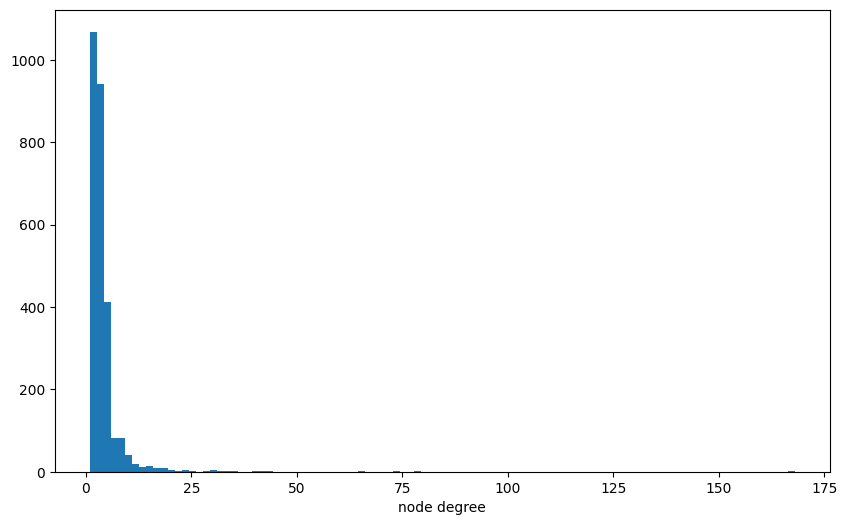

In [7]:
deg_distribution(graph)

In [8]:
def class_distribution(graph, labels):
  counter = collections.Counter(graph.y.numpy())
  counter = dict(counter)
  unique_labels = graph.y.unique()
  labels_name = {i.item(): labels[i.item()] for i in unique_labels}
  count = [x[1]/len(graph.x) for x in sorted(counter.items())]
  plt.figure(figsize=(6, 4))
  plt.bar(unique_labels, count)
  plt.xticks(unique_labels, labels_name.values(), rotation=90)
  plt.title("Class distribution")
  plt.show()


In [9]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

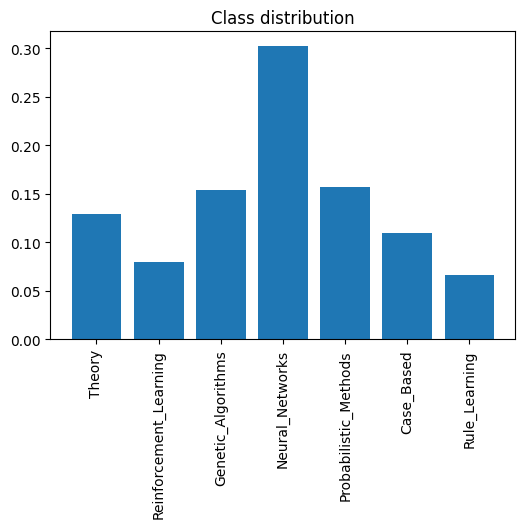

In [10]:
class_distribution(graph, label_dict)

The term **homophily** refers to the fact that similar nodes in a graph are often connected. So let's see in what proportion the connections within the graph are between nodes with the same class and how many are between different classes.

In [11]:
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter

def homophily_plot(graph):
  source_labels = graph.y[graph.edge_index[0]].numpy()
  target_labels = graph.y[graph.edge_index[1]].numpy()

  connected_labels_set = np.stack((source_labels, target_labels), axis=0)

  label_connection_counts = []
  for i in range(len(graph.y.unique())):
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)

  label_connection_counts = np.array(label_connection_counts)
  row_sums = np.sum(label_connection_counts, axis=1)
  non_zero_mask = row_sums != 0
  label_connection_counts_scaled = np.zeros_like(label_connection_counts, dtype=float)
  label_connection_counts_scaled[non_zero_mask] = label_connection_counts[non_zero_mask] / row_sums[non_zero_mask, np.newaxis]
  plt.figure(figsize=(6, 6))
  plt.rcParams["font.size"] = 10
  hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
  plt.xlabel("class",size=12)
  plt.ylabel("class",size=12)
  plt.tight_layout()
  plt.show()


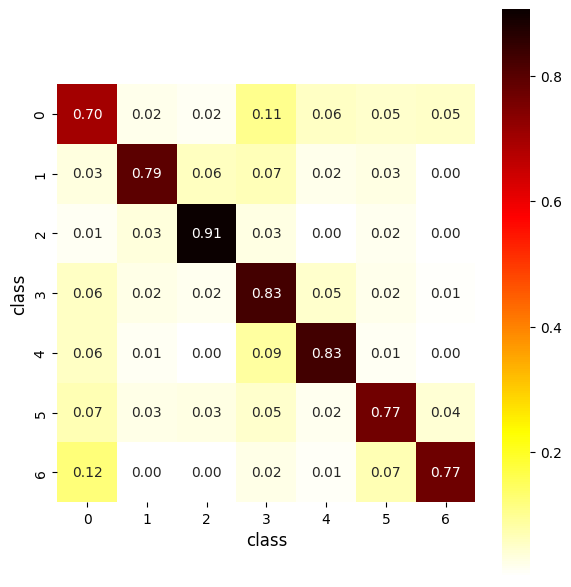

In [12]:
homophily_plot(graph)

Let's visualize the entire graph

In [13]:
def visualize_graph(graph, title):
  net = to_networkx(graph, to_undirected=True)
  node_color = []
  nodelist = [[], [], [], [], [], [], []]
  colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
  labels = graph.y
  for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

  pos = nx.spring_layout(net, seed = 42)
  plt.figure(figsize = (10, 10))
  labellist = list(label_dict.values())
  for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(net, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)

  nx.draw_networkx_edges(net, pos, width = 0.5)
  plt.legend()
  plt.axis('off')
  plt.title(title)
  plt.show()
  plt.close()

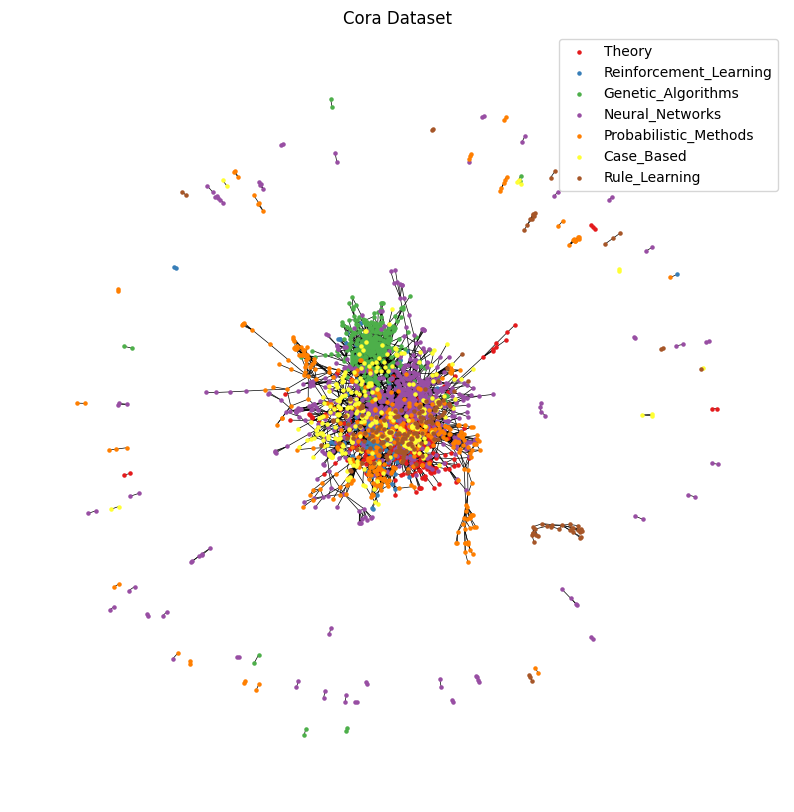

In [14]:
visualize_graph(graph, "Cora Dataset")

Although much larger datasets with millions of nodes exist in the literature, this graph already has a size large enough to justify the use of sampling methods and not too large that it cannot be handled easily enough in a notebook.

We would like to maintain most of the properties of the dataset seen in this section by applying sampling and reducing the dimensions.

In [15]:
def num_samples(graph, size_reduction):
  num_samples_nodes = int(graph.num_nodes * (1 - size_reduction))
  num_samples_edges = int(graph.num_edges * (1 - size_reduction))
  return num_samples_nodes, num_samples_edges

All the experiments that follow will be performed in accordance with the number of samples now defined on the nodes or edges depending on the technique.


The termination conditions usually used are a certain constant number of iterations (deterministic criterion) or a certain number of different nodes explored (stochastic criterion).


Given the lack of domain expert knowledge, every time we have to sample edges or nodes we will use a degree-induced distribution, in order to favor the exploration of **hubs** of the network, under the hypothesis that densely crowded areas surround nodes of high importance.
Depending on whether the entire graph or only the neighborhood of a node $\mathcal{N}(v_i)$ is considered, the normalization constants of the various distributions considered will change.


In the event that the stochastic algorithm defines a progressive path in the graph that allows returning to nodes already considered, the number of returns obtained can be plotted as the degree varies.

In [16]:
def node_dist_plot(node_dist_dict):
  graph = dataset[0]
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)

  plt_val = []

  for key, value in node_dist_dict.items():
    deg = degs[key].item()
    plt_val.append([deg, value])

  plt_val = np.array(plt_val)

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.set_xlabel('Node Degree')
  ax.set_ylabel('Node count')
  ax.bar(plt_val[:, 0], plt_val[:, 1], label='Count')
  ax.tick_params(axis='y')

  fig.tight_layout()
  plt.title("Node Degree and Value Distribution")
  plt.show()

In [17]:
def analyze_sampling(graph, title, node_dist=None):
  graph_info(graph)
  deg_distribution(graph)
  class_distribution(graph, label_dict)

  if node_dist is not None:
    node_dist_plot(node_dist)

  homophily_plot(graph)
  visualize_graph(graph, title)

## Vertex Sampling (VS)

First $V_S\subset V$ nodes are sampled uniformly or in accordance with some distribution if knowledge about the domain is available and then $G_S=(V_S, E_S)$ is defined with $E_S \subset E$ is the set of all the edges we can take from $E$ such that they connect two nodes sampled in $V_S$. In our case we will use the distribution on the nodes:
$$
\pi_{v_i} = \frac{d_G(v_i)}{\sum_{v_k \in V} d_G(v_k)}
$$

In [18]:
def vertex_sampling(graph, num_samples):
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, num_samples, replace=False, p=probs)
  sample_nodes = graph.x[node_samp_ids]
  sample_edges_index, _ = subgraph(torch.tensor(node_samp_ids),
                                                   graph.edge_index,
                                                   graph.edge_attr,
                                   relabel_nodes = True)
  sample_y = graph.y[node_samp_ids]

  sample_graph = Data(x=sample_nodes, edge_index=sample_edges_index, y=sample_y)

  return sample_graph

In [19]:
num_samples_nodes, _ = num_samples(graph, 0.7)
vs_graph = vertex_sampling(graph, num_samples_nodes)

Number of nodes: 812
Number of edges: 2080
Has isolated nodes: True
Has self-loops: False
Is undirected: True
Average node degree: 2.56
Number of classes: 7
Number of connected components: 147
Average clustering coefficient: 0.19835
Density: 0.00316
Transitivity: 0.10741


count  mean  std  min  25%  50%  75%   max
0  812.0  2.56  3.4  0.0  1.0  2.0  3.0  63.0

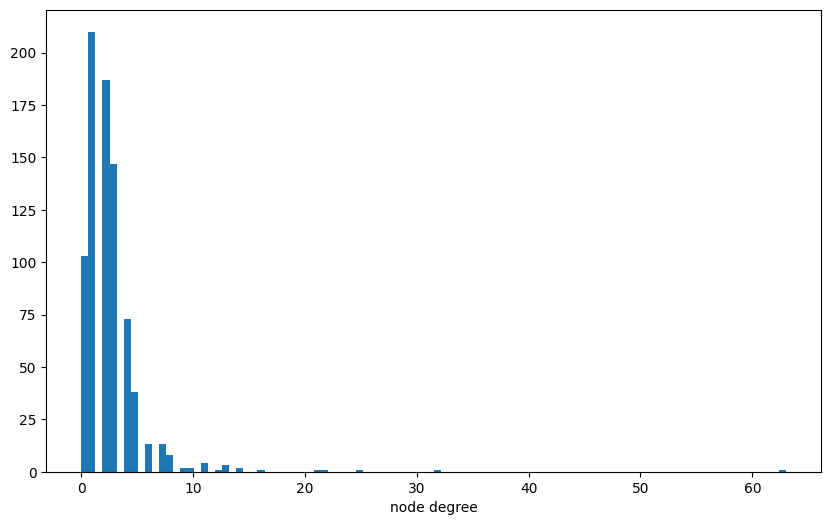

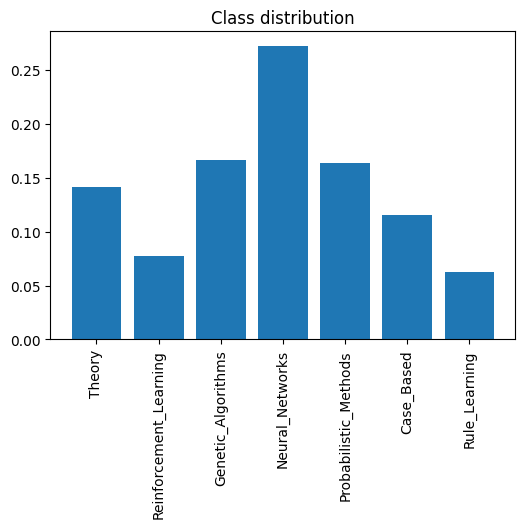

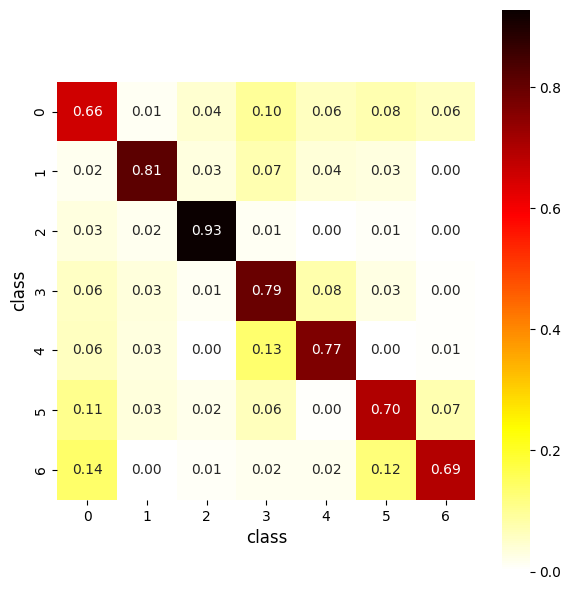

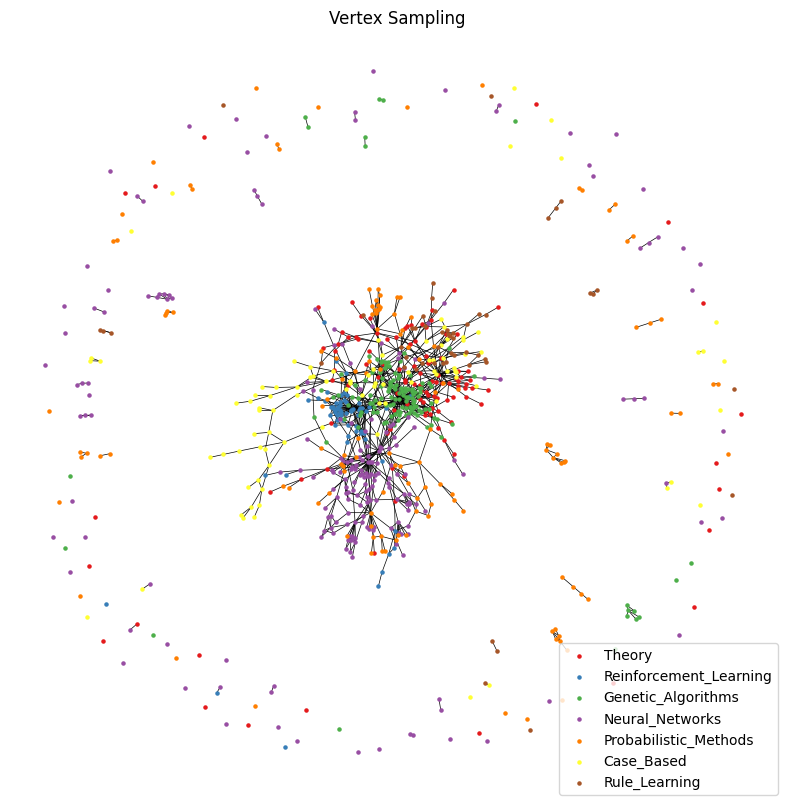

In [20]:
analyze_sampling(vs_graph, "Vertex Sampling")

## Vertex Sampling with Neighbourhood (VSN)

We first sample $\tilde{V}_S \subset V$ nodes and then set $V_S = \tilde{V}_S \cup \bigcup_{v \in \tilde{V}_S} \mathcal{N}(v)$ equal to the union of the sampled nodes and their entire neighborhood. Consequently we will have that $E_S = \bigcup_{v \in \tilde{V}_S} \delta(v)$ is the set of all edges incident to all nodes in $\tilde{V}_S$.

In [21]:
def vertex_sampling_neighbourhood(graph, num_samples):

  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, num_samples, replace=False, p=probs)
  node_samp_ids, sample_edges, _, _  = k_hop_subgraph(torch.tensor(node_samp_ids),
                                                     1,
                                                     graph.edge_index,
                                                     relabel_nodes=True)
  sample_nodes = graph.x[node_samp_ids]
  sample_y = graph.y[node_samp_ids]

  sample_graph = Data(x=sample_nodes, edge_index=sample_edges, y=sample_y)
  return sample_graph

In [22]:
num_samples_nodes, _ = num_samples(graph, 0.95)
vsn_graph = vertex_sampling_neighbourhood(graph, num_samples_nodes)

Number of nodes: 993
Number of edges: 4042
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 4.07
Number of classes: 7
Number of connected components: 15
Average clustering coefficient: 0.38694
Density: 0.00410
Transitivity: 0.08226


count  mean   std  min  25%  50%  75%    max
0  993.0  4.07  7.05  1.0  2.0  3.0  4.0  168.0

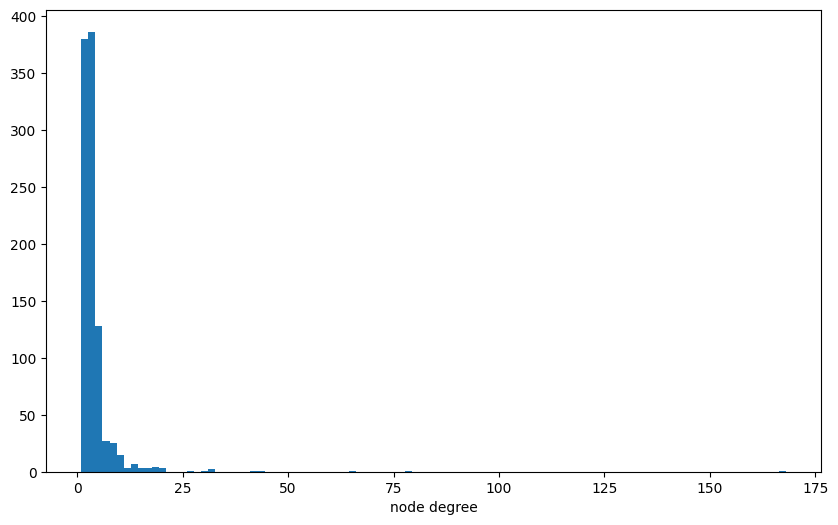

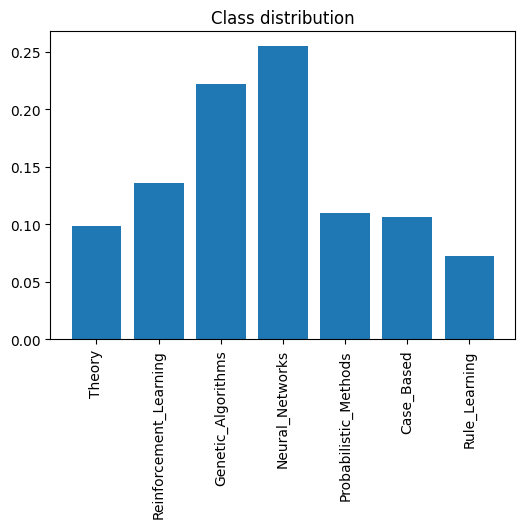

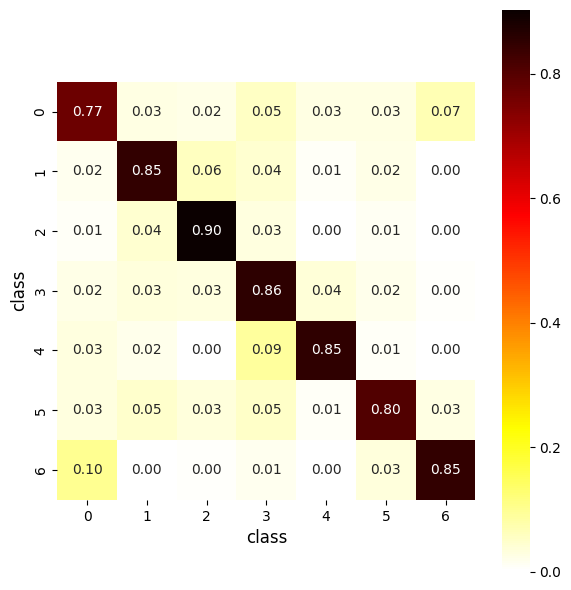

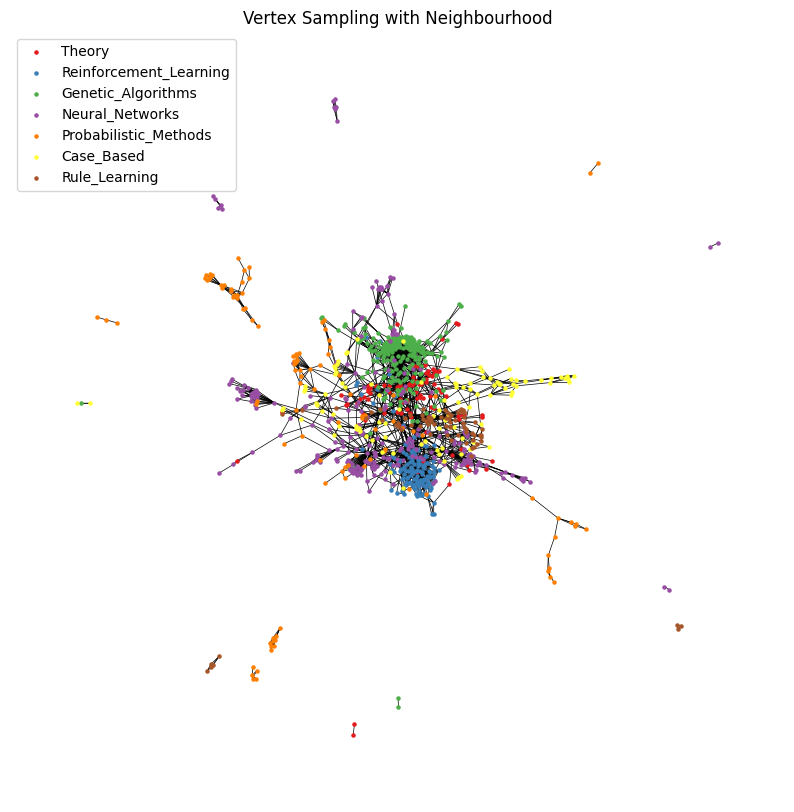

In [23]:
analyze_sampling(vsn_graph, "Vertex Sampling with Neighbourhood")

## Edge Sampling (ES)

In the opposite way to before, we first sample a certain number of edges $E_S$ and then we define the sampling graph $G_S=(V_S, E_S)$ in which $V_S$ is the set of all the nodes that appear in at least one of the sampled edges.

The distribution used on the edges is:
$$
\pi_{e_{ij}} = \frac{d_G(v_i) + d_G(v_j)}{\sum_{e_{kz} \in E} d_G(v_k) + d_G(v_z)}
$$
in which, compared to uniform distribution, more importance is given to edges that connect highly connected nodes in the network.


In [24]:
def relabel_edge_index(node_ids, edge_index):
  node_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(node_ids)}
  relabeled_edge_index = torch.zeros_like(edge_index)
  for count, edge in enumerate(edge_index.t()):
    relabeled_edge_index.t()[count] = torch.tensor([node_mapping[edge[0].item()], node_mapping[edge[1].item()]])

  return relabeled_edge_index


def edge_sampling(graph, num_samples):

  num_unique_edges = int(num_samples * 0.5)
  sorted_edge_index = torch.sort(graph.edge_index, dim=0)[0]

  degs = degree(sorted_edge_index[0], graph.num_nodes)
  t_edge_index = sorted_edge_index.t()
  edge_probs = degs[t_edge_index[:,0:1].squeeze()] + degs[t_edge_index[:,1:2].squeeze()]
  edge_probs = (edge_probs / torch.sum(edge_probs)).reshape(1, -1)

  edge_index = torch.cat((sorted_edge_index, edge_probs))

  unique_edge_index, _ = torch.unique(edge_index, dim=1, return_inverse=True)

  final_probs = 2 * unique_edge_index.t()[:,2:3].squeeze()

  edge_samp_ids = np.sort(np.random.choice(unique_edge_index.shape[1],
                                           num_unique_edges,
                                           replace=False,
                                           p = final_probs
                                           ))

  sample_edges = (unique_edge_index[0:2, edge_samp_ids]).to(torch.long)

  sample_edges = to_undirected(sample_edges)

  sample_nodes_ids = sample_edges.t()[:,0:1].squeeze().unique()
  sample_nodes = graph.x[sample_nodes_ids]

  sample_y = graph.y[sample_nodes_ids]

  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph

In [25]:
_, num_sample_edges = num_samples(graph, 0.9)
es_graph = edge_sampling(graph, num_sample_edges)

Number of nodes: 648
Number of edges: 1054
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 1.63
Number of classes: 7
Number of connected components: 133
Average clustering coefficient: 0.01551
Density: 0.00251
Transitivity: 0.00332


count  mean   std  min  25%  50%  75%   max
0  648.0  1.63  4.31  1.0  1.0  1.0  1.0  95.0

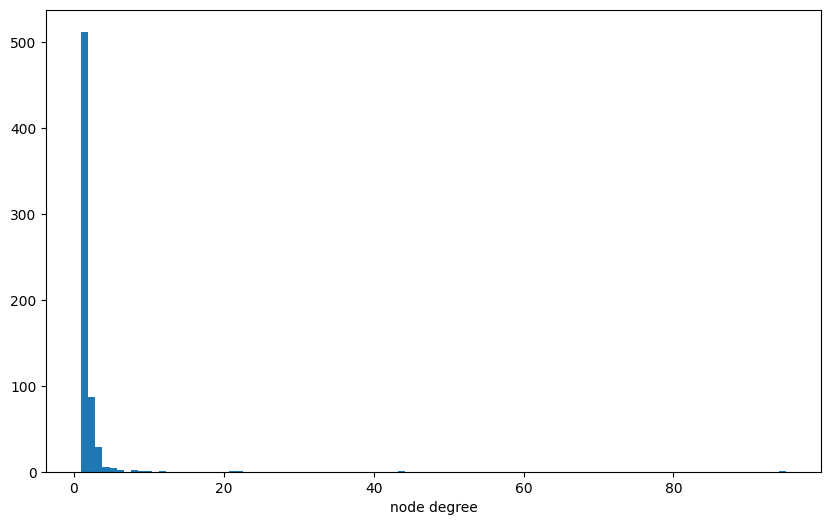

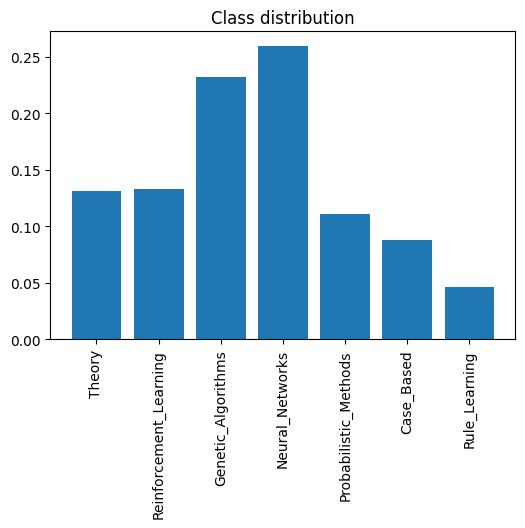

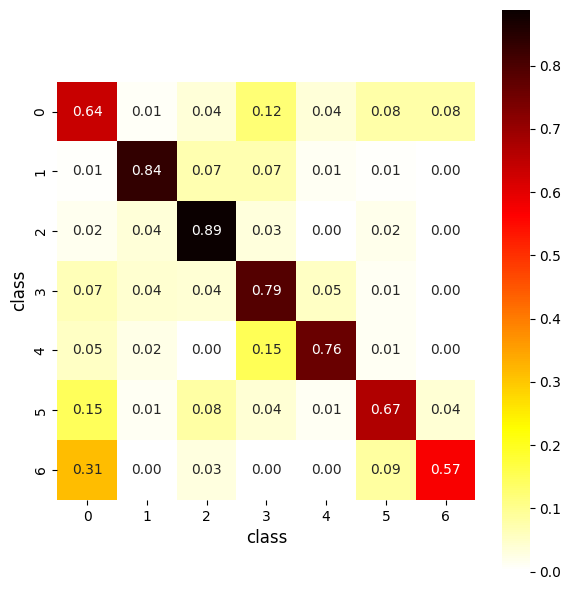

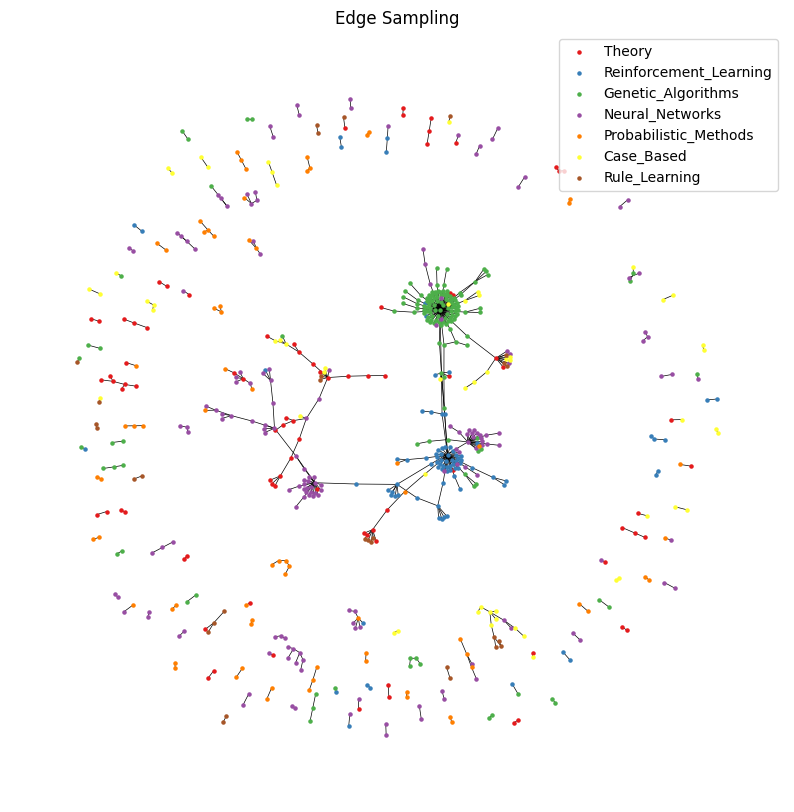

In [26]:
analyze_sampling(es_graph, "Edge Sampling")

## Traversal Based Sampling

This family of methods includes all algorithms that take the topology of the network into account during sampling.

### Breadth/ Depth/ Random First Sampling

Start by sampling a single node $v_0\in V$ and insert it into a queue $Q$ and by setting $V_S = E_S = \emptyset$. At each iteration, until the desired sampling size is reached:
- extract a node $v$ from $Q$;
- update $V_S = V_S \cup \{v\}$ and $E_S=E_S \cup \{(u,v)\}$ where $u$ is the node that added $v$ in $Q$ because $v\in \mathcal{N}(u)$;
- add to $Q$ all the neighbors $u \in \mathcal{N}(v)$ of the extracted node such that $u \notin Q$ and $u \notin V_S$.

Depending on how it is extracted from $Q$ we obtain the following algorithms:
- **BFS**: always extract from top of $Q$;
- **DFS**: always extract from the bottom of $Q$;
- **RFS**: extract randomly.

In [27]:
def b_d_r_first_sampling(graph, extract, num_samples):
  if extract != "BFS" and extract != "DFS" and extract != "RFS":
    raise ValueError("extract must be BFS, DFS or RFS")

  sample_nodes_ids = np.array([], dtype=int)
  sample_edges = []
  visited = np.array([], dtype=int)
  start_id = np.random.choice(graph.num_nodes, 1, replace=False)
  edges_in_queue = []
  queue = np.array([], dtype=int)
  queue = np.append(queue, start_id)
  while len(sample_nodes_ids) < num_samples:
    if extract == "BFS":
      node_id = queue[0]
      queue = queue[1:]
    elif extract == "DFS":
      node_id = queue[-1]
      queue = queue[:-1]
    elif extract == "RFS":
      id = np.random.choice(len(queue), 1)
      node_id = queue[id].item()
      queue = np.delete(queue, [id])

    neighs, _, _, _  = k_hop_subgraph(torch.tensor([node_id]),
                                                     1,
                                                     graph.edge_index)
    visited = np.append(visited, node_id)
    for neigh in neighs:
      neigh = neigh.item()
      if neigh not in visited and neigh not in queue:
        queue = np.append(queue, neigh)
        edge = np.array([node_id, neigh])
        edges_in_queue.append(edge)

    if len(sample_nodes_ids) > 0:
      for edge in edges_in_queue:
        if edge[0] == node_id or edge[1] == node_id:
          sample_edges.append(edge)
          break
      edges_in_queue = [e for e in edges_in_queue if not np.array_equal(e, edge)]


    sample_nodes_ids = np.append(sample_nodes_ids, node_id)

  sample_edges = torch.tensor(np.array(sample_edges)).t()
  sample_nodes = graph.x[sample_nodes_ids]
  sample_y = graph.y[sample_nodes_ids]

  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph

In [28]:
num_samples_nodes, _ = num_samples(graph, 0.7)
bfs_graph = b_d_r_first_sampling(graph, "BFS", num_samples_nodes)

Number of nodes: 812
Number of edges: 811
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Average node degree: 1.00
Number of classes: 7
Number of connected components: 1
Average clustering coefficient: 0.00000
Density: 0.00246
Transitivity: 0.00000


count  mean  std  min  25%  50%  75%    max
0  812.0   2.0  6.9  1.0  1.0  1.0  1.0  161.0

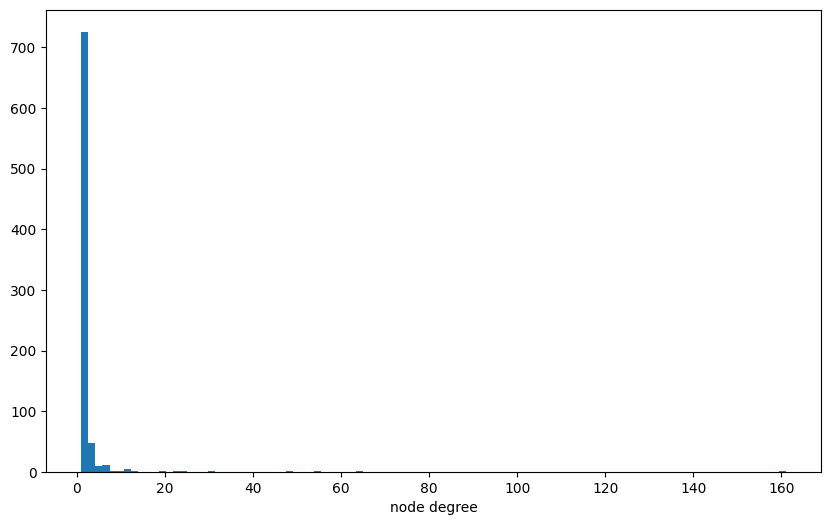

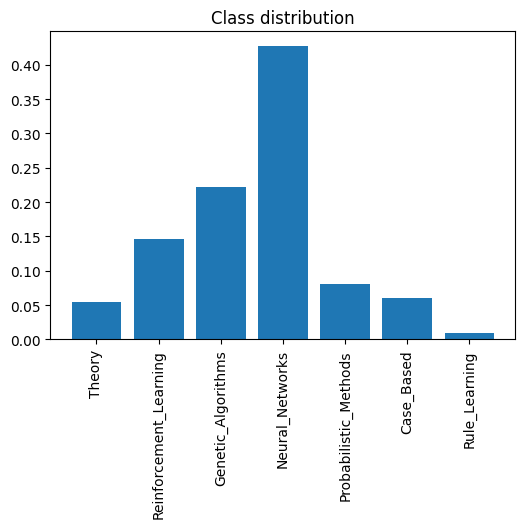

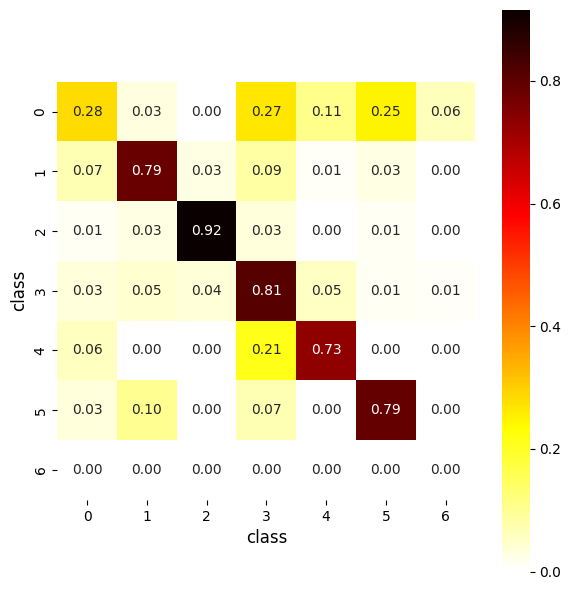

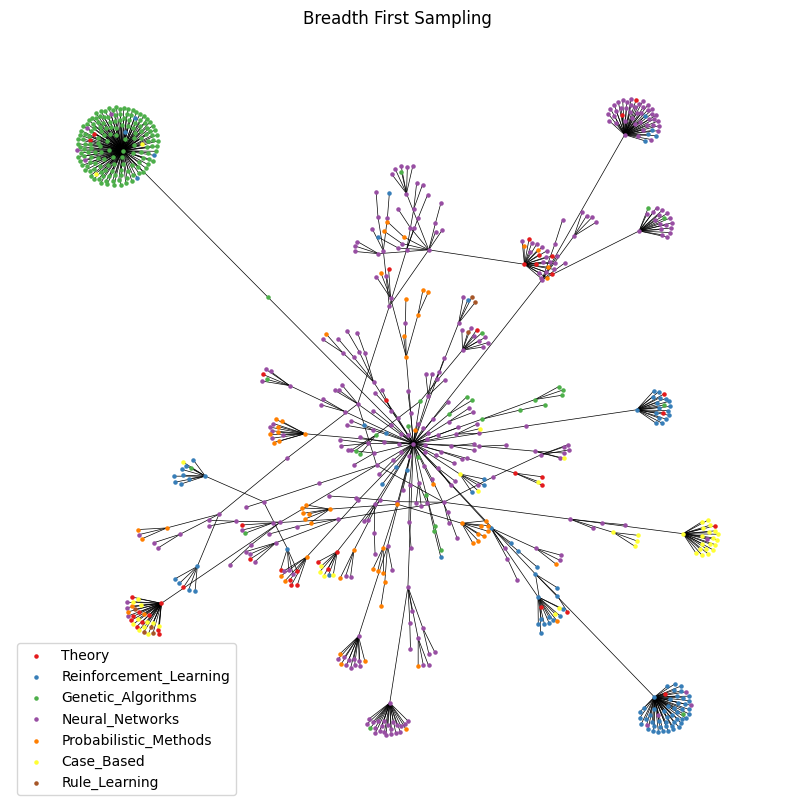

In [29]:
analyze_sampling(bfs_graph, "Breadth First Sampling")

In [30]:
depth_graph = b_d_r_first_sampling(graph, "DFS", num_samples_nodes)

Number of nodes: 812
Number of edges: 811
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Average node degree: 1.00
Number of classes: 7
Number of connected components: 1
Average clustering coefficient: 0.00000
Density: 0.00246
Transitivity: 0.00000


count  mean   std  min  25%  50%  75%   max
0  812.0   2.0  1.31  1.0  1.0  2.0  2.0  13.0

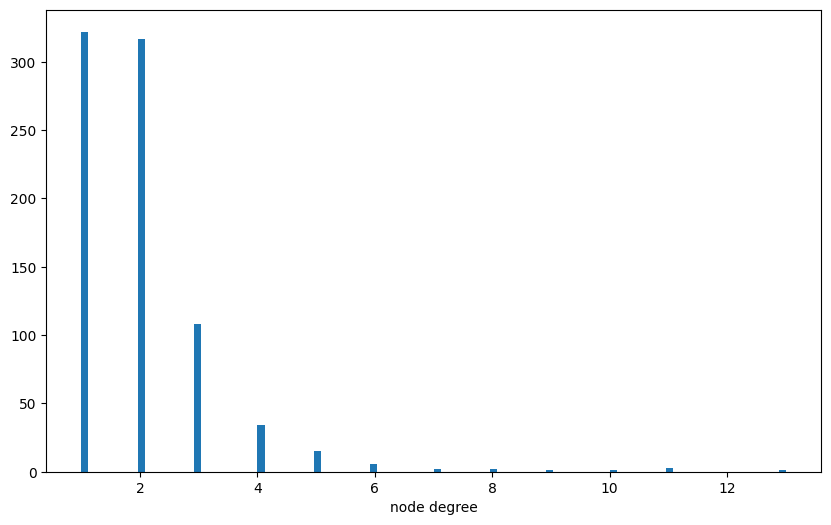

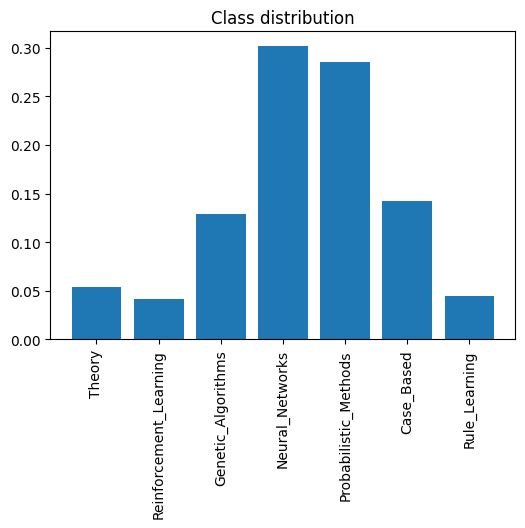

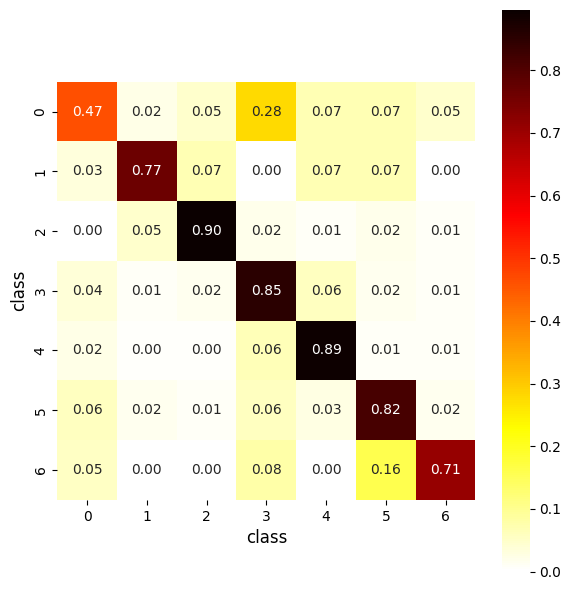

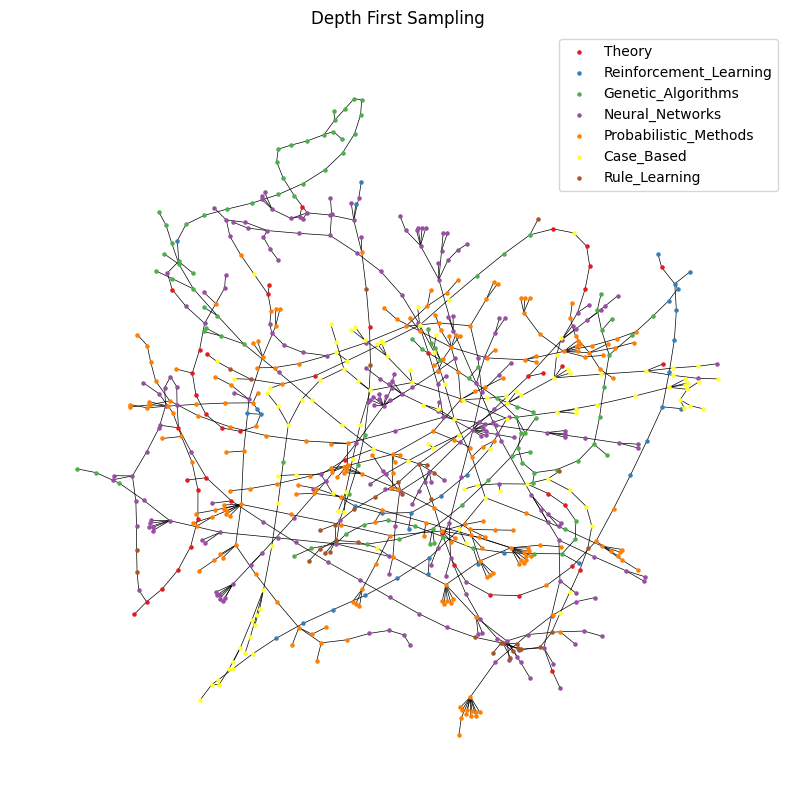

In [31]:
analyze_sampling(depth_graph, "Depth First Sampling")

In [32]:
rfs_graph = b_d_r_first_sampling(graph, "RFS", num_samples_nodes)

Number of nodes: 812
Number of edges: 811
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Average node degree: 1.00
Number of classes: 7
Number of connected components: 1
Average clustering coefficient: 0.00000
Density: 0.00246
Transitivity: 0.00000


count  mean   std  min  25%  50%  75%   max
0  812.0   2.0  2.58  1.0  1.0  1.0  2.0  31.0

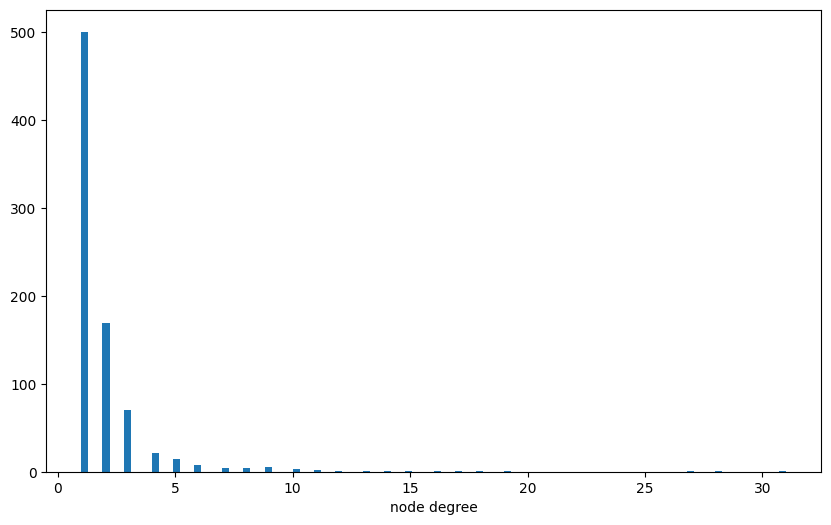

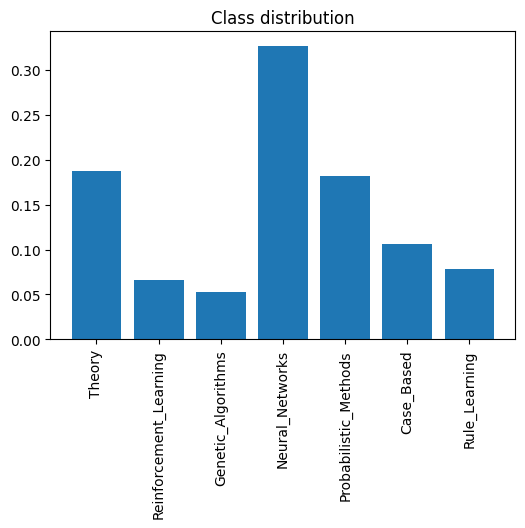

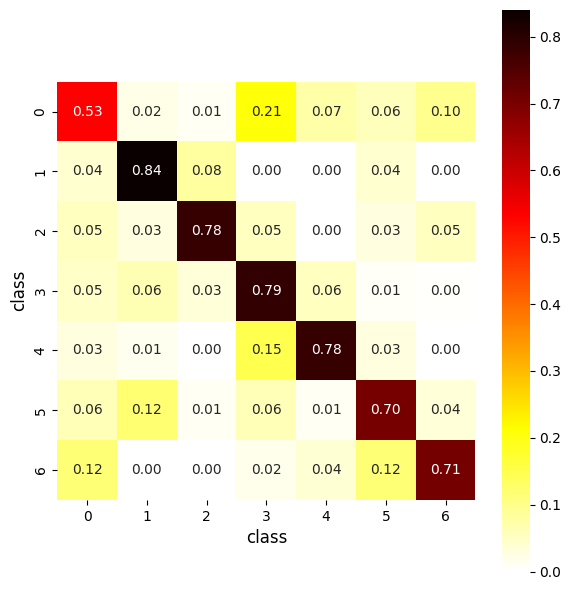

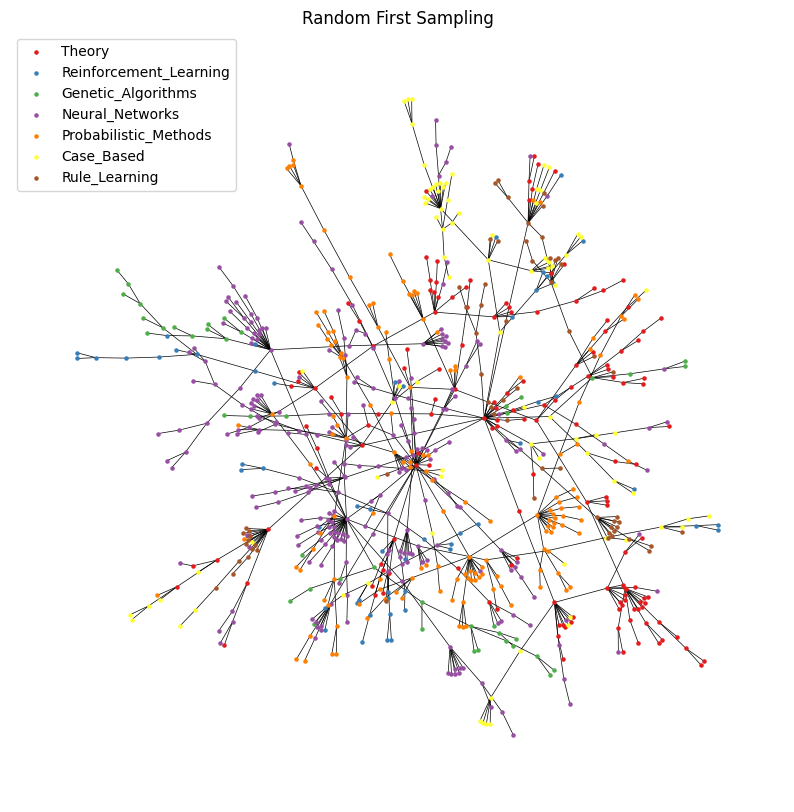

In [33]:
analyze_sampling(rfs_graph, "Random First Sampling")

### Snow-Ball Sampling (SBS)

The sampling algorithm is as follows:
- Start from an initial set of nodes $V^{(0)}$ obtained through expert knowledge or from a sampling on $V$;
- At each iteration $i$:
  - get $k$ new neighbors from each node in $V^{(i-1)}$ and define with $E^{(i)}$ the set of edges used;
  - create the set $\tilde{V}^{(i)}$ composed of all nodes in $V^{(i-1)}$ and all $k$ neighbors sampled for each node;
  - update $V^{(i)} = \tilde{V}^{(i)} - \bigcup_{j=0}^{i-1} V^{(j)}$
- Once the maximum number of iterations $T$ is reached, return $G_S=(V_S, E_S)$ with $V_S= \bigcup_{t=0}^T V^{(t)}$ and $E_S= \bigcup_{t=0 }^T E^{(t)}$.

In [60]:
def snow_ball_sampling(graph, start_dim, num_iter, k):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, start_dim, replace=False, p=probs)
  all_nodes = set()
  v = set()
  v.update(node_samp_ids.flatten())
  all_nodes.update(v)
  all_edges = []
  node_dist_dict = {}

  for _ in range(num_iter):

    v_tilde = set()
    v_tilde.update(v)
    all_neighs = set()

    for node_id in v:
      neighs, _, _, _  = k_hop_subgraph(torch.tensor([node_id]),
                                                     1,
                                                     graph.edge_index)

      if not node_id in node_dist_dict:
        node_dist_dict[node_id] = 1
      else:
        node_dist_dict[node_id] += 1

      mask = neighs != node_id
      neighs = neighs[mask]
      
      if(len(neighs) <= k):
        all_neighs.update(neighs.numpy().flatten())

        for n in neighs:
          n = n.item()
          all_edges.append([node_id, n])

          if not n in node_dist_dict:
            node_dist_dict[n] = 1
          else:
            node_dist_dict[n] += 1

      else:
        neighs_deg = degs[neighs].numpy()
        probs = neighs_deg / np.sum(neighs_deg)
        k_neighs = np.random.choice(neighs, k, replace=False, p=probs)
        all_neighs.update(k_neighs.flatten())

        for n in k_neighs:
          n = n.item()
          all_edges.append([node_id, n])

          if not n in node_dist_dict:
            node_dist_dict[n] = 1
          else:
            node_dist_dict[n] += 1

    v_tilde.update(all_neighs)
    v = v_tilde - all_nodes
    all_nodes.update(v)

  sample_edges = torch.tensor(np.array(all_edges)).t()
  sample_edges = coalesce(sample_edges)
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes_ids = sample_edges.t()[:,0:1].unique().squeeze()
  sample_nodes = graph.x[sample_nodes_ids]
  sample_y = graph.y[sample_nodes_ids]
  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph, node_dist_dict

In [61]:
sbs_graph, node_dist_dict = snow_ball_sampling(graph, 10, 8, 3)

Number of nodes: 782
Number of edges: 2622
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.35
Number of classes: 7
Number of connected components: 2
Average clustering coefficient: 0.15276
Density: 0.00429
Transitivity: 0.11266


count  mean   std  min  25%  50%  75%   max
0  782.0  3.35  2.93  1.0  2.0  3.0  4.0  59.0

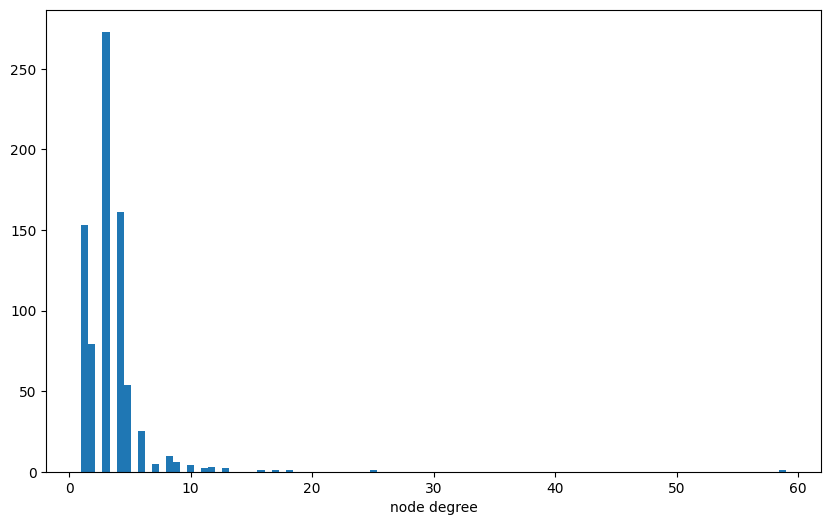

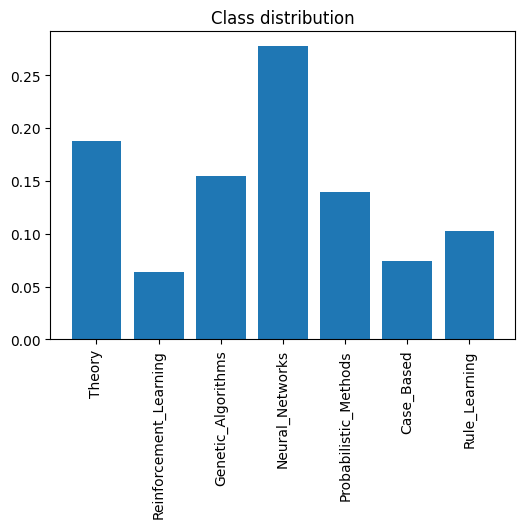

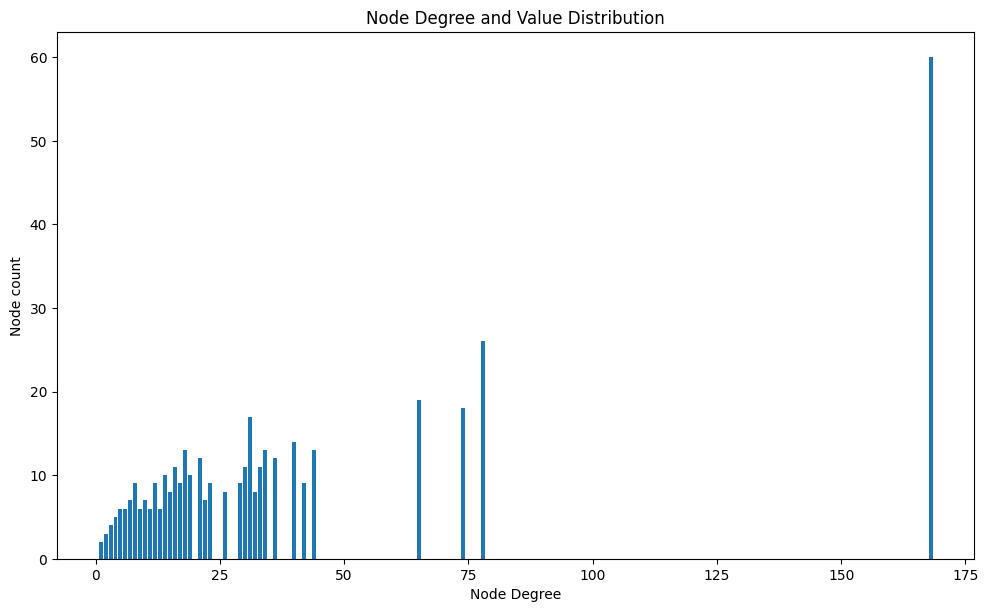

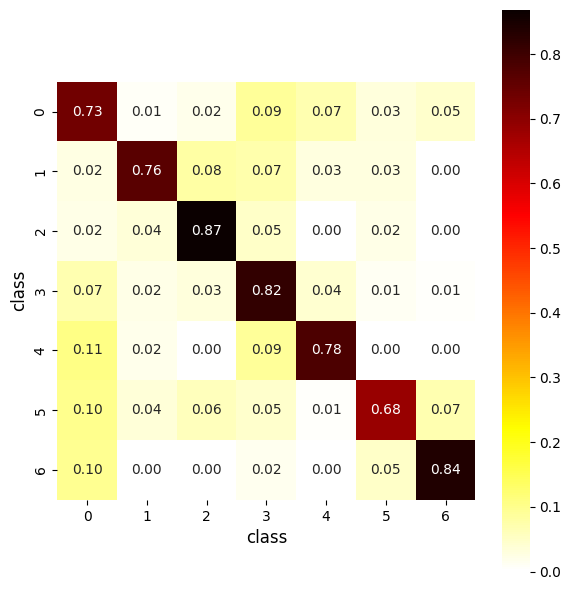

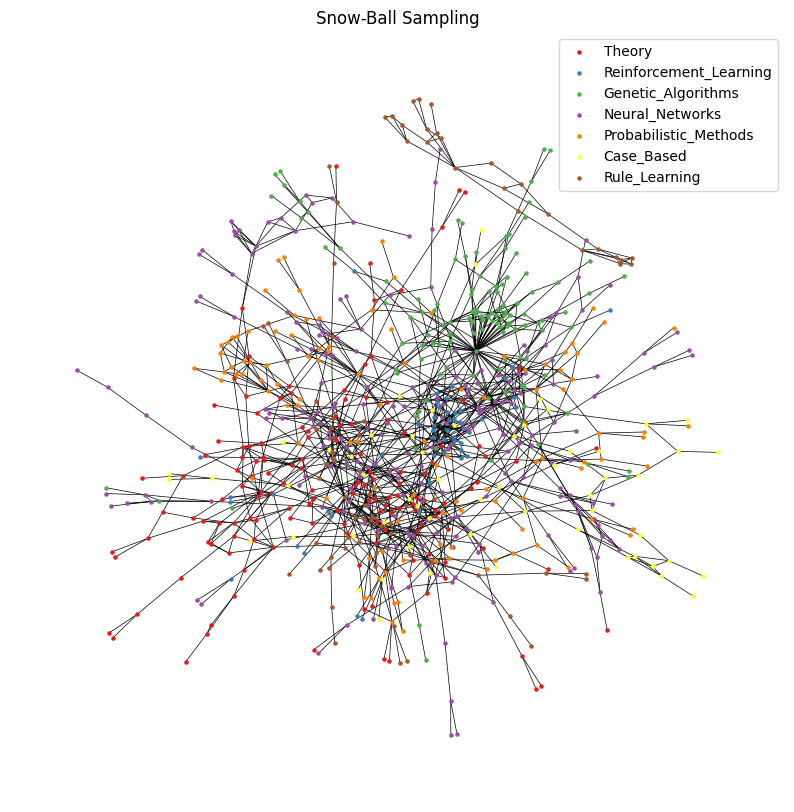

In [62]:
analyze_sampling(sbs_graph, "Snow-Ball Sampling", node_dist_dict)

### Forest Fire Sampling (FFS)

It is like Snow-Ball Sampling with the only difference that the number $k$ of neighbors to sample from each node at each iteration is not a fixed number, but is generated according to $K \sim \texttt{Geometric} (p)$. If $p=\frac{1}{k}$ then we have that $\mathbb{E}[K]=k$ the two techniques coincide on average.

In [63]:
def forest_fire_sampling(graph, num_iter, start_dim, p):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, start_dim, replace=False, p=probs)
  all_nodes = set()
  v = set()
  v.update(node_samp_ids.flatten())
  all_nodes.update(v)
  all_edges = []
  node_dist_dict = {}

  for _ in range(num_iter):

    v_tilde = set()
    v_tilde.update(v)
    all_neighs = set()


    for node_id in v:
      neighs, _, _, _  = k_hop_subgraph(torch.tensor([node_id]),
                                                     1,
                                                     graph.edge_index)

      if not node_id in node_dist_dict:
        node_dist_dict[node_id] = 1
      else:
        node_dist_dict[node_id] += 1

      k = np.random.geometric(p)
      
      mask = neighs != node_id
      neighs = neighs[mask]
      
      if(len(neighs) <= k):
        all_neighs.update(neighs.numpy().flatten())

        for n in neighs:
          n = n.item()
          all_edges.append([node_id, n])

          if not n in node_dist_dict:
            node_dist_dict[n] = 1
          else:
            node_dist_dict[n] += 1

      else:
        neighs_deg = degs[neighs].numpy()
        probs = neighs_deg / np.sum(neighs_deg)
        k_neighs = np.random.choice(neighs, k, replace=False, p=probs)
        all_neighs.update(k_neighs.flatten())

        for n in k_neighs:
          n = n.item()
          all_edges.append([node_id, n])

          if not n in node_dist_dict:
            node_dist_dict[n] = 1
          else:
            node_dist_dict[n] += 1

    v_tilde.update(all_neighs)
    v = v_tilde - all_nodes
    all_nodes.update(v)

  sample_edges = torch.tensor(np.array(all_edges)).t()
  sample_edges = coalesce(sample_edges)
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes_ids = sample_edges.t()[:,0:1].unique().squeeze()
  sample_nodes = graph.x[sample_nodes_ids]
  sample_y = graph.y[sample_nodes_ids]
  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph, node_dist_dict

In [64]:
ffs_graph, node_dist_dict = forest_fire_sampling(graph, 8, 10, p=0.33)

Number of nodes: 515
Number of edges: 1538
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.99
Number of classes: 7
Number of connected components: 3
Average clustering coefficient: 0.15060
Density: 0.00581
Transitivity: 0.11757


count  mean   std  min  25%  50%  75%   max
0  515.0  2.99  2.48  1.0  2.0  2.0  4.0  40.0

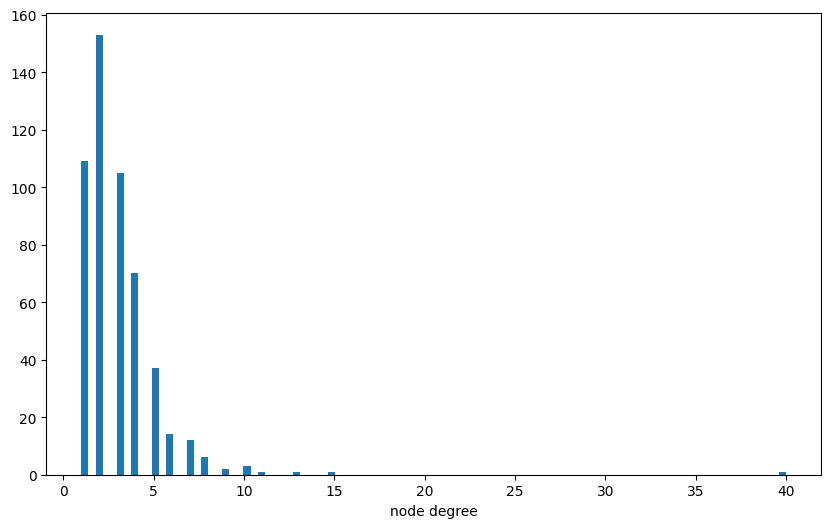

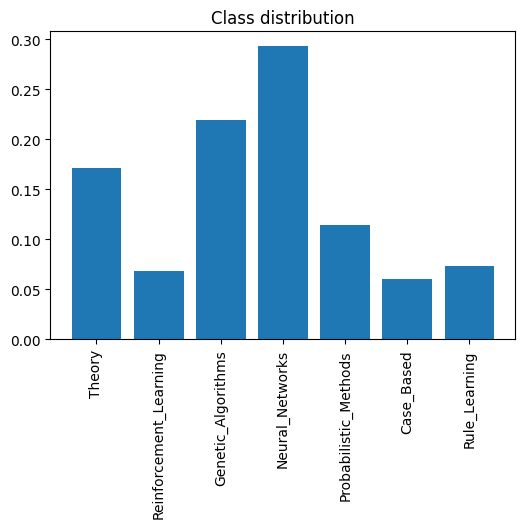

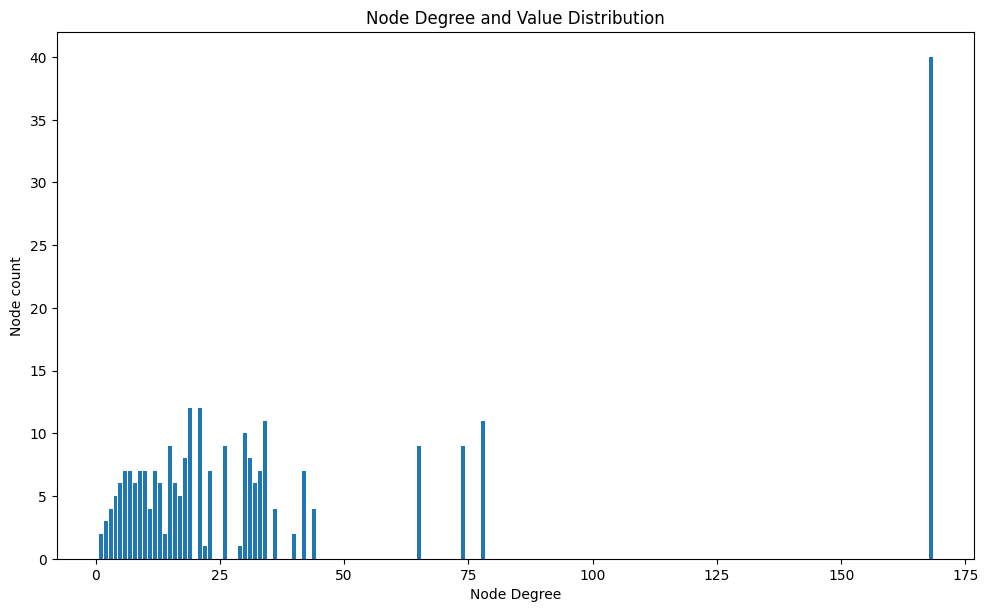

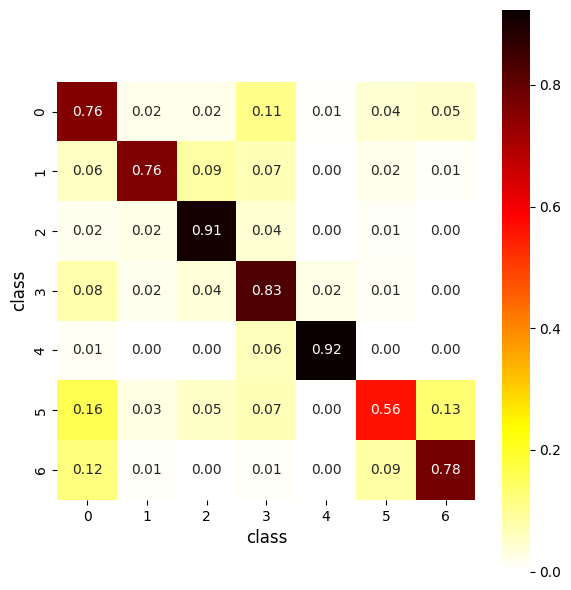

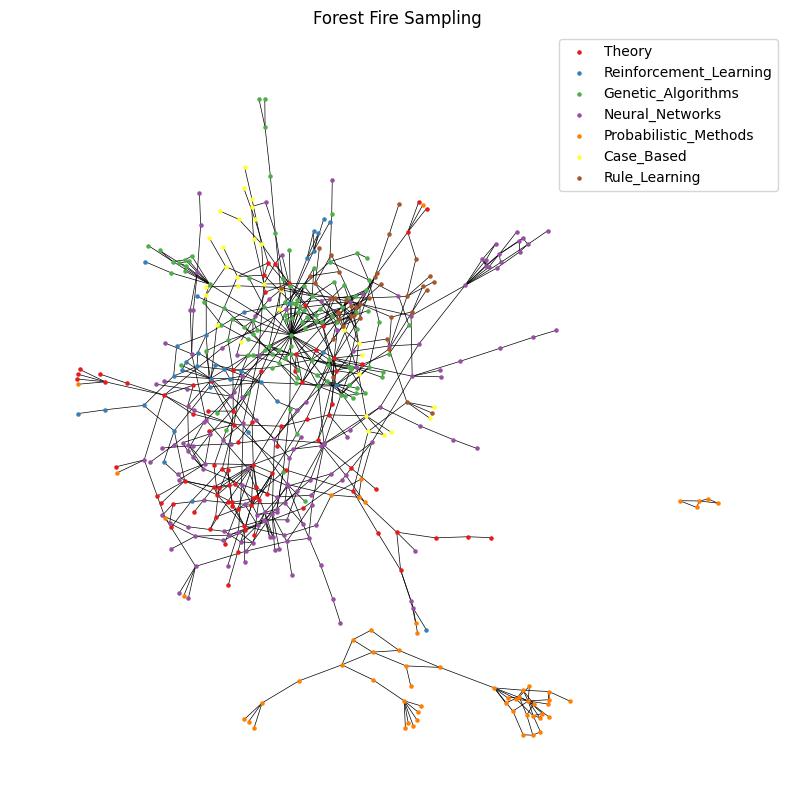

In [65]:
analyze_sampling(ffs_graph, "Forest Fire Sampling", node_dist_dict)

### Random Walk

Start from a random node $v_0 \in V$, insert it into $V_S$, and at each step, until a certain termination condition is reached:
- samples uniformly (or according to some distribution) the next node among the neighbors $v_j \in \mathcal{N}(v_i)$ of the current node $v_i$;
- add $v_j \in V_S$;
- add the edge $(v_i, v_j)\in E_S$

Return $G_S=(V_S, E_S)$.

In [78]:
def random_walk_sampling(graph, num_samples, force, start=None, relabel=True):

  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  
  if start is None:
    curr_id = np.random.choice(graph.num_nodes, 1, replace=False)
    curr_id = curr_id.item()
  else:
    curr_id = start

  edges = []
  node_ids = np.array([], dtype=int)
  node_ids = np.append(node_ids, curr_id)
  node_dist_dict = {}
  n_it = 0

  while len(node_ids) < num_samples:
    n_it += 1
    neighs, _, _, _  = k_hop_subgraph(torch.tensor([curr_id]),
                                                     1,
                                                     graph.edge_index)
    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] = 1
    else:
      node_dist_dict[curr_id] += 1

    mask = neighs != curr_id
    neighs = neighs[mask]
    neighs_deg = degs[neighs].numpy()
    probs = neighs_deg / np.sum(neighs_deg)
    new_id = np.random.choice(neighs, 1, replace=False, p = probs)
    new_id = new_id.item()

    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
    curr_id = new_id


  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  
  if relabel:
    relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
    sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  else:
    sample_graph = Data(x=sample_nodes, edge_index=sample_edges, y=sample_y)


  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", len(edges), " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")

  return sample_graph, node_dist_dict

In [79]:
num_samples_nodes, _ = num_samples(graph, 0.85)
rw_graph, node_dist_dict = random_walk_sampling(graph, num_samples_nodes, True)

1048 iterations required to explore  406  different nodes


Number of nodes: 406
Number of edges: 1058
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.61
Number of classes: 7
Number of connected components: 1
Average clustering coefficient: 0.13014
Density: 0.00643
Transitivity: 0.02094


count  mean   std  min  25%  50%  75%    max
0  406.0  2.61  5.89  1.0  1.0  2.0  2.0  104.0

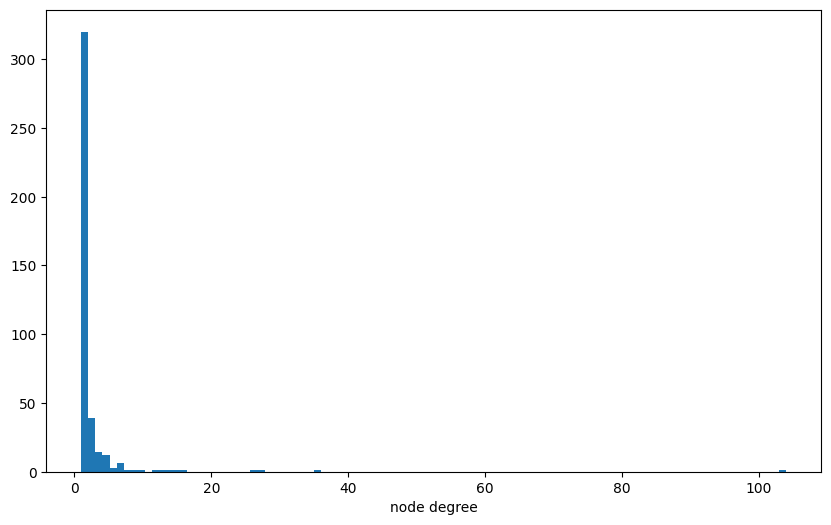

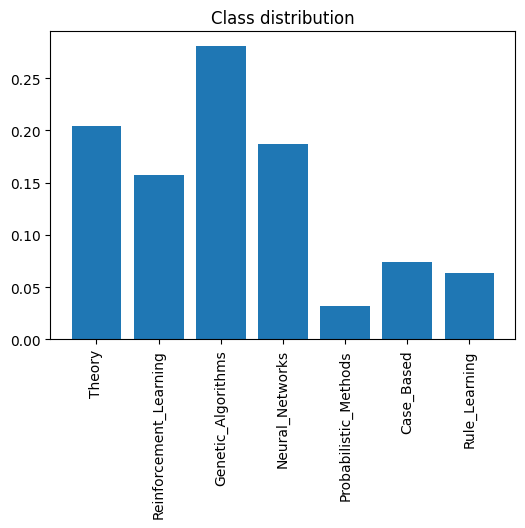

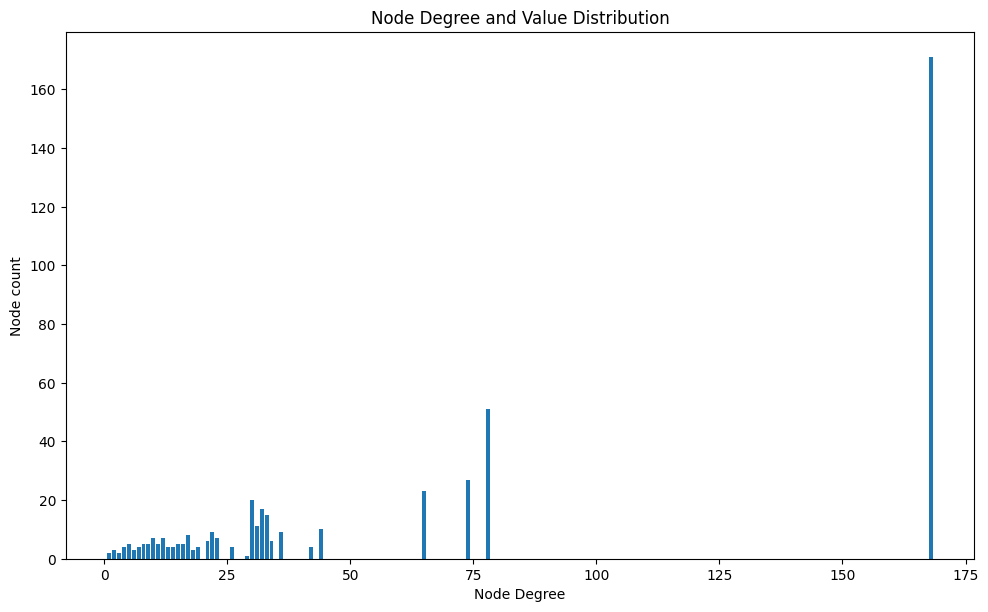

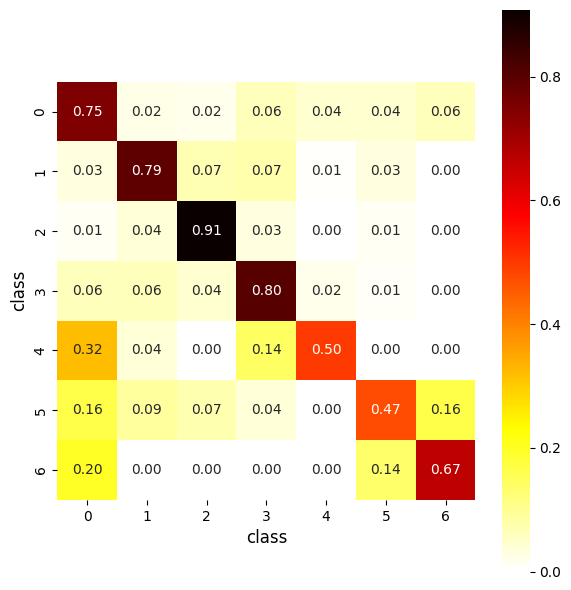

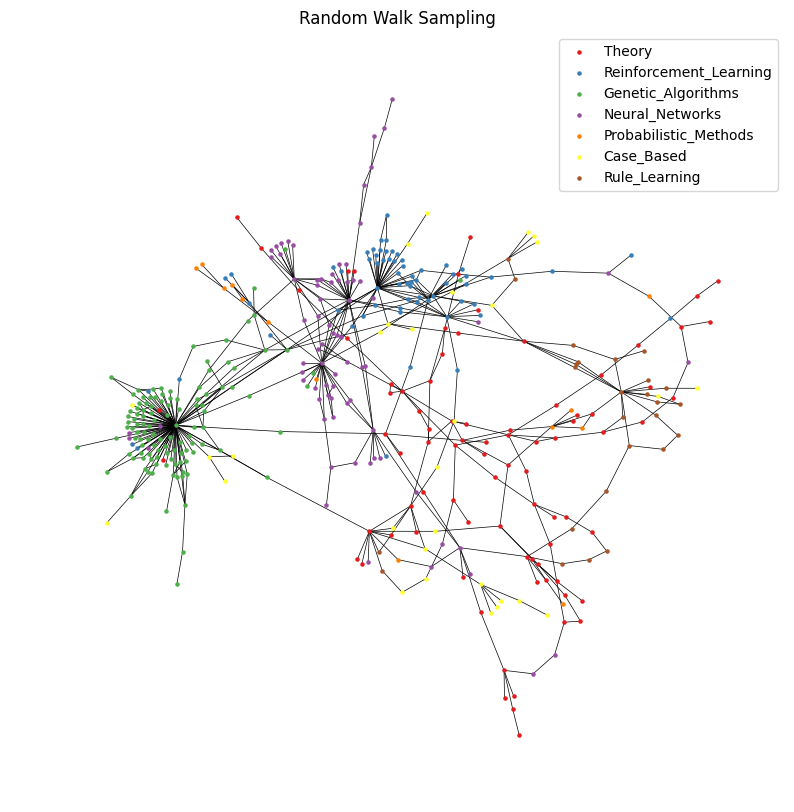

In [80]:
analyze_sampling(rw_graph, "Random Walk Sampling", node_dist_dict)

### Random Walk with Escaping (RWE)

It is a random walk in which there is a non-zero probability of jumping to any non-nearby node. This idea was proposed in Pagerank to make the chain aperiodic and irreducible.

In [81]:
def random_walk_sampling_escaping(graph, num_samples, force, escape_prob):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  curr_id = np.random.choice(graph.num_nodes, 1, replace=False, p=probs)
  curr_id = curr_id.item()
  edges = []
  node_ids = np.array([], dtype=int)
  node_ids = np.append(node_ids, curr_id)
  node_dist_dict = {}
  n_it = 0

  while len(node_ids) < num_samples:
    n_it += 1
    neighs, _, _, _  = k_hop_subgraph(torch.tensor([curr_id]),
                                                     1,
                                                     graph.edge_index)
    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] = 1
    else:
      node_dist_dict[curr_id] += 1

    neighs_deg = degs[neighs].numpy()
    curr_pos = np.where(neighs == curr_id)[0].item()
    neighs_deg[curr_pos] = 0
    
    escape_id = -1
    
    while escape_id == -1:
      escape_id = np.random.choice(graph.num_nodes, 1, replace=False).item()
      if escape_id in neighs:
        escape_id = -1
    
    neighs[curr_pos] = escape_id
    probs = np.zeros_like(neighs_deg)
    probs[curr_pos] = escape_prob
    probs = neighs_deg / np.sum(neighs_deg)
    new_id = np.random.choice(neighs, 1, replace=False, p = probs)
    new_id = new_id.item()

    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
    curr_id = new_id


  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", len(edges), " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")

  

  return sample_graph, node_dist_dict


In [82]:
rwe_sampling, node_dist_dict = random_walk_sampling_escaping(graph, num_samples_nodes, force=True, escape_prob=0.1)

1171 iterations required to explore  406  different nodes


Number of nodes: 406
Number of edges: 1072
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.64
Number of classes: 7
Number of connected components: 1
Average clustering coefficient: 0.18602
Density: 0.00652
Transitivity: 0.02312


count  mean   std  min  25%  50%  75%    max
0  406.0  2.64  6.71  1.0  1.0  2.0  2.0  124.0

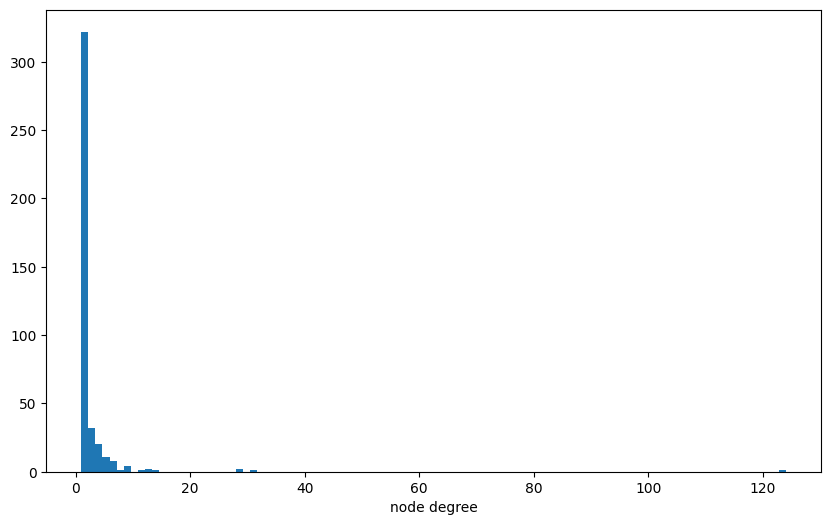

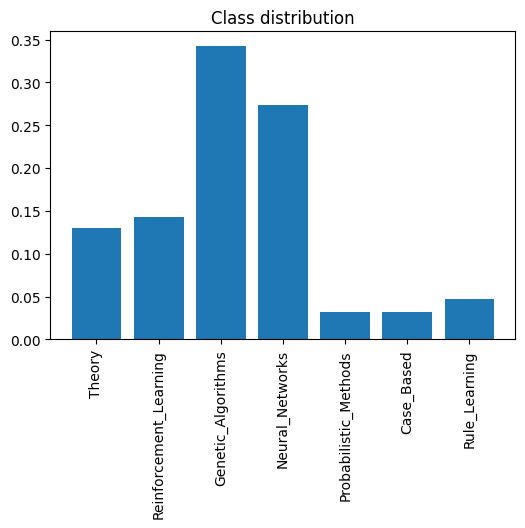

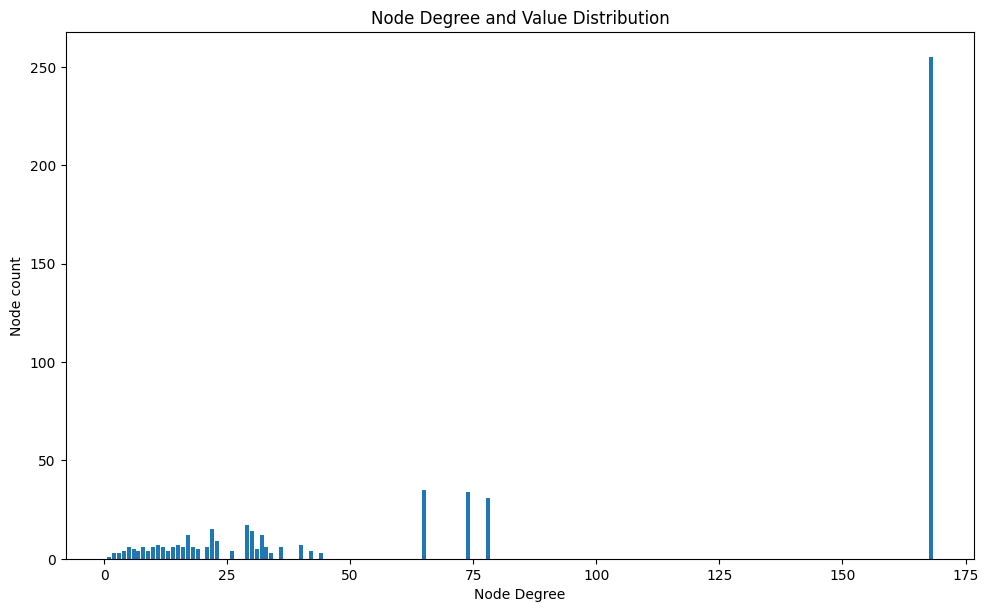

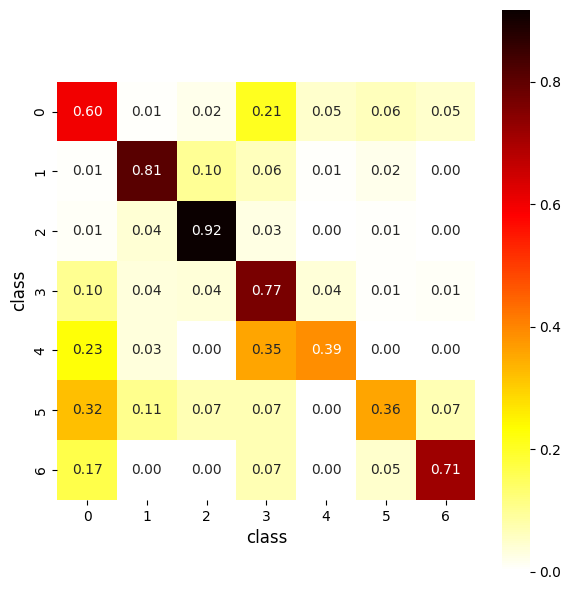

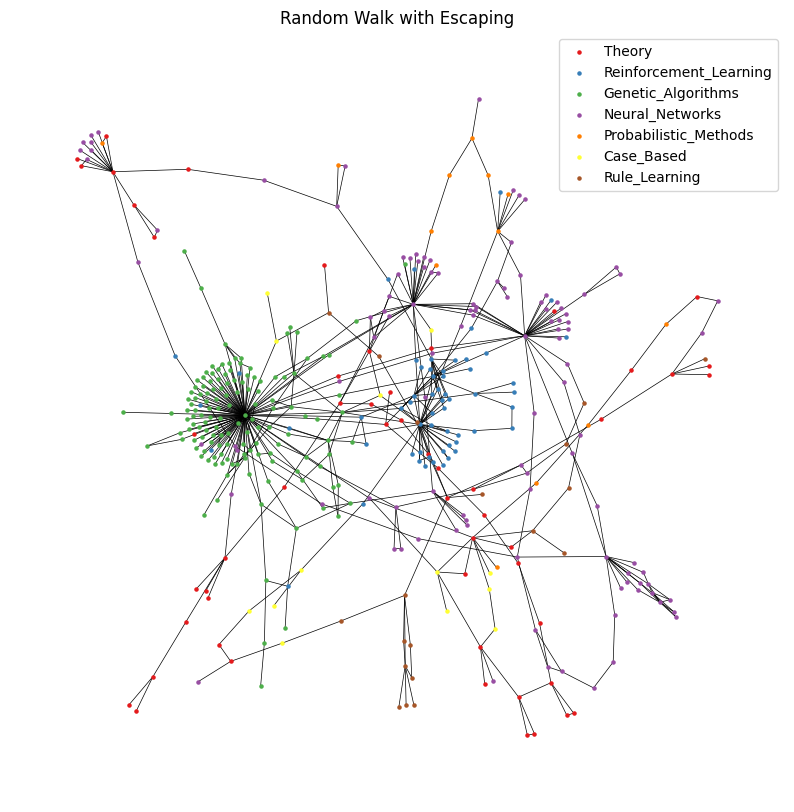

In [83]:
analyze_sampling(rwe_sampling, "Random Walk with Escaping", node_dist_dict)

### Metropolis-Hastings Random Walk

It is an algorithm usually used to obtain a certain desired distribution on the nodes. Denoted by $P_{uv}$ the matrix with the transition probabilities $u \to v$ and by $\pi_u$ the value of the distribution $\boldsymbol{\pi}$ on $u$, we have:
$$
P_{uv} =
\begin{cases}
M_{uv} \cdot \min\left\{1, \frac{\pi_v}{\pi_u} \right\} \qquad & u \neq v \:\land \: v \in \mathcal{N}( u)\\
0 & u \neq v \: \land \: v \notin \mathcal{N}(u)\\
1 - \sum_{w \in V} P_{uw} & u = v
\end{cases}
$$
Where $M_{uv}=M_{vu}$ is a normalization constant for the node pair $(u,v)$. A small value of $M_{uv}$ underweights all the probabilities of undertaking an outgoing edge from $u$ and consequently gives high importance to self-loops and dilates the mixing time for the desired node distribution. A classic choice is $M_{uv} = \min \left\{\frac{1}{d_G(u)}, \frac{1}{d_G(v)}\right\}$.

In accordance with what was said before, we will use $\boldsymbol{\pi}$ as distribution:
$$
\forall v \in V \quad \pi_v = \frac{d_G(v)}{\sum_{u \in V} d_G(u)} \:\:\implies\:\: \min\left\{1 , \frac{\pi_v}{\pi_u} \right\} = \min\left\{1, \frac{d_G(v)}{d_G(u)} \right\}
$$
in order to promote travel to very crowded areas of the network.

Leaving this aside, the procedure is identical to the random walk: it starts from a node $v_0\in V$ and, at each step it samples, starting from the current $v_i$ it samples the next $v_{i+1}$ to which it moves and update $V_S = V_S \cup \{v_{i+1}\}$, $E_S = E_S \cup \{\{v_{i}, v_{i+1}\}\}$.

In [84]:
def metropolis_hastings_random_walk_sampling(graph, num_samples, force):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  curr_id = np.random.choice(graph.num_nodes, 1, replace=False, p=probs)
  curr_id = curr_id.item()
  edges = []
  node_ids = np.array([], dtype=int)
  node_ids = np.append(node_ids, curr_id)
  node_dist_dict = {}
  n_it = 0

  while len(node_ids) < num_samples:
    n_it = n_it + 1
    neighs, _, _, _  = k_hop_subgraph(torch.tensor([curr_id]),
                                                     1,
                                                     graph.edge_index)
    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] = 1
    else:
      node_dist_dict[curr_id] += 1

    neighs_deg = degs[neighs].numpy()
    probs = np.zeros_like(neighs, dtype=float)
    curr_pos = np.where(neighs == curr_id)[0].item()

    for j in range(len(neighs)):
      if j != curr_pos:
        prob = min(1/neighs_deg[j],  1/ neighs_deg[curr_pos]) * min(1, neighs_deg[j]/neighs_deg[curr_pos])
        probs[j] = prob

    probs[curr_pos] = 1 - np.sum(probs)
    probs = np.clip(probs, 0, None)
    probs = probs / np.sum(probs)

    new_id = np.random.choice(neighs, 1, p=probs)
    new_id = new_id.item()

    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
    curr_id = new_id

  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", sample_edges.shape[1], " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")


  return sample_graph, node_dist_dict

In [85]:
num_samples_nodes, _ = num_samples(graph, 0.85)
mhrw_graph, node_dist_dict = metropolis_hastings_random_walk_sampling(graph, num_samples_nodes, force=True)

2080 iterations required to explore  406  different nodes


Number of nodes: 406
Number of edges: 1000
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.46
Number of classes: 7
Number of connected components: 1
Average clustering coefficient: 0.09037
Density: 0.00608
Transitivity: 0.12659


count  mean   std  min  25%  50%  75%   max
0  406.0  2.46  1.19  1.0  2.0  2.0  3.0  10.0

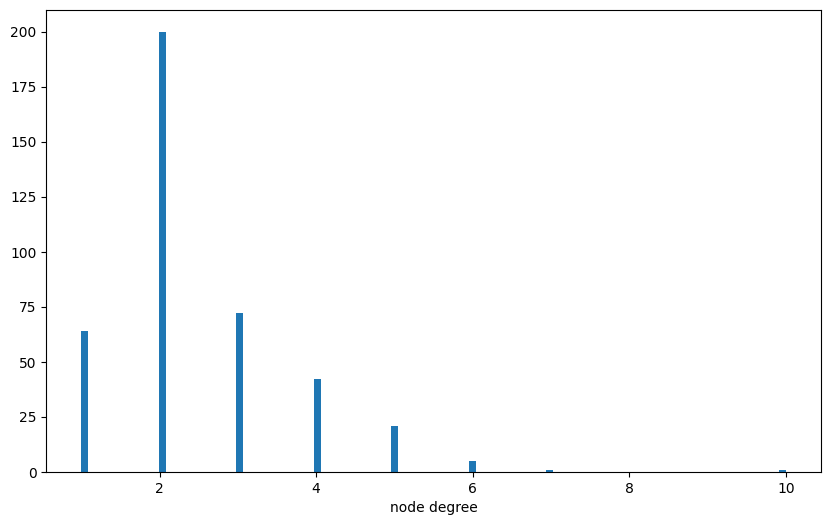

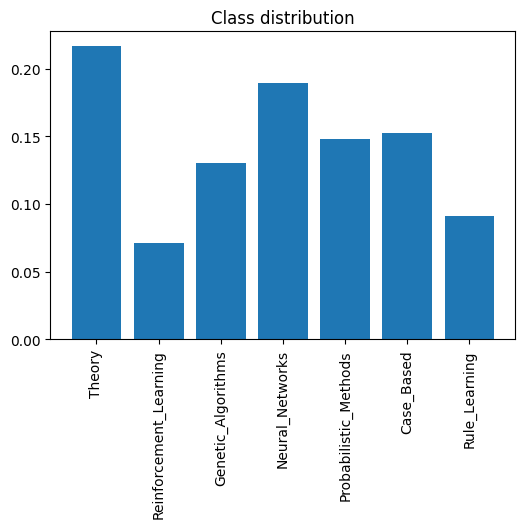

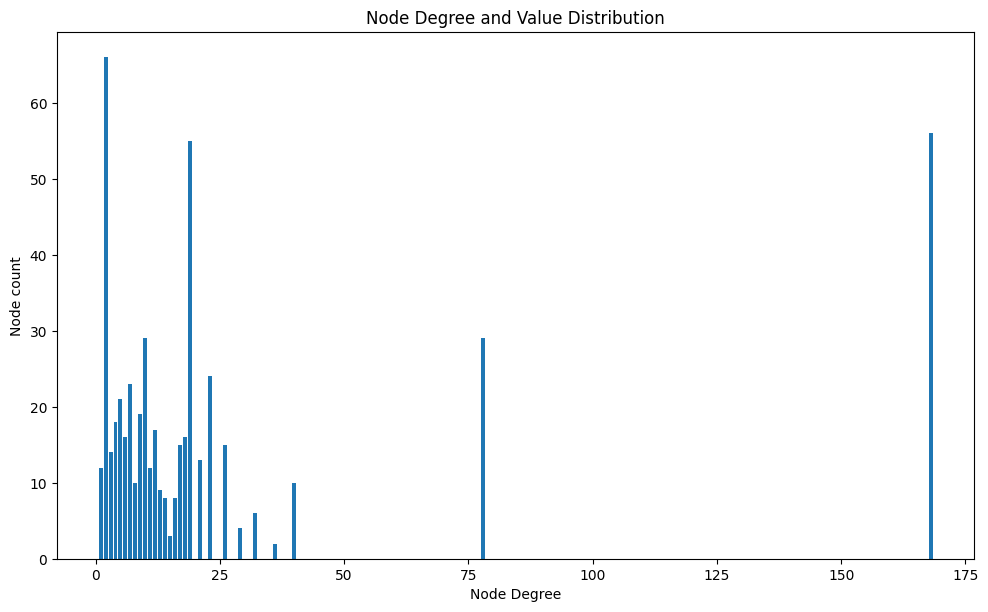

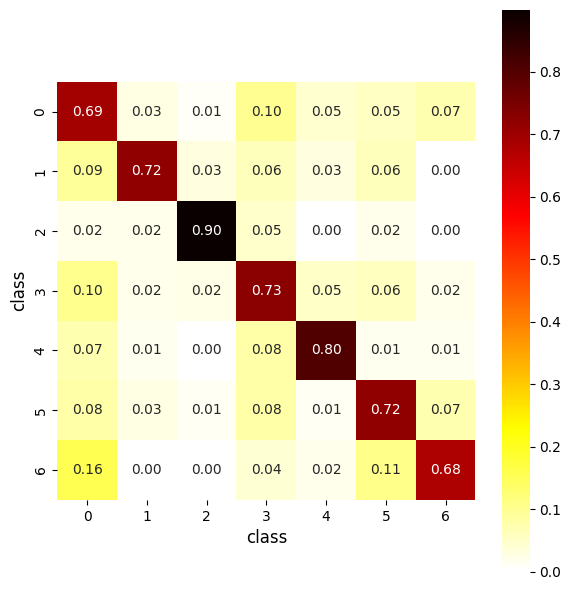

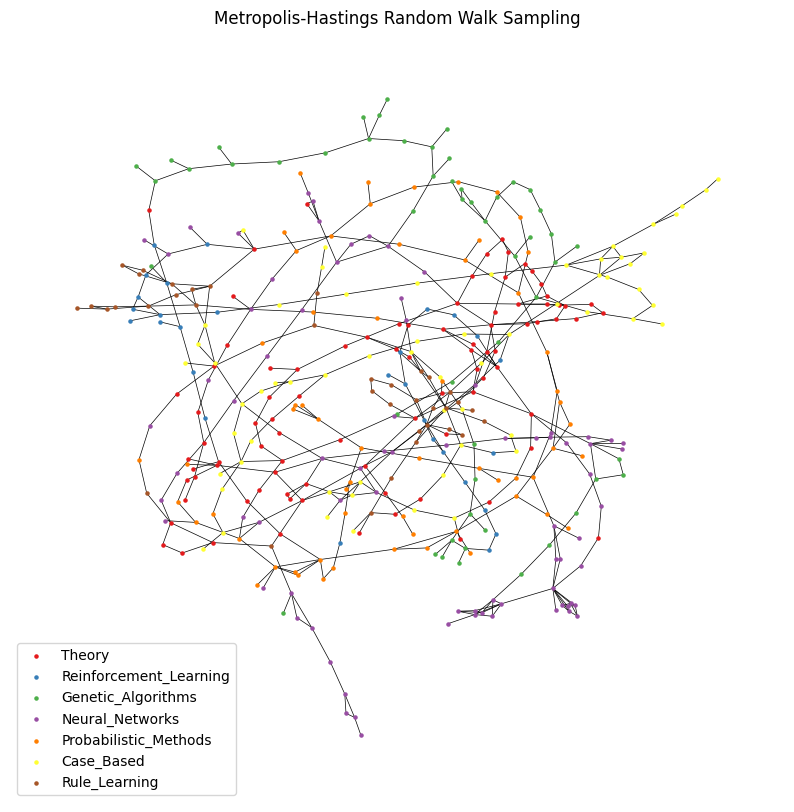

In [86]:
analyze_sampling(mhrw_graph, "Metropolis-Hastings Random Walk Sampling", node_dist_dict)

### Multiple Independent Random Walkers (MIRW)

It's simply a set of different random walks. To explore different areas of the graph, $l$ different starting points are defined and $l$ independent random walks are performed, the set of all edges and nodes obtained are returned.

In [87]:
def multiple_independent_random_walkers(graph, num_samples, num_random_walks, force):
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, num_random_walks, replace=False, p=probs)

  all_node_dist_dict = None
  all_sample_graph = Data(x=None, edge_index=None, y=None)
  num_samples_walk = int(num_samples / num_random_walks)

  for i in range(num_random_walks):
    curr_id = node_samp_ids[i]
    sample_graph, node_dist_dict = random_walk_sampling(graph, num_samples_walk, force, start=curr_id, relabel=False)

    if all_node_dist_dict is None:
      all_sample_graph = sample_graph
      all_node_dist_dict = node_dist_dict
    else:
      new_edge_index = torch.cat((all_sample_graph.edge_index, sample_graph.edge_index), dim=1)
      new_edge_index, _ = remove_self_loops(new_edge_index)
      new_edge_index = to_undirected(new_edge_index)
      node_ids = new_edge_index.t()[:,0:1].unique().squeeze()
      all_sample_graph.edge_index = new_edge_index
      all_sample_graph.x = graph.x[node_ids]
      all_sample_graph.y = graph.y[node_ids]

      for k, v in node_dist_dict.items():
        if k in all_node_dist_dict:
          all_node_dist_dict[k] += v
        else:
          all_node_dist_dict[k] = v


  node_ids = all_sample_graph.edge_index.t()[:,0:1].unique().squeeze()
  relabeled_edge_index = relabel_edge_index(node_ids, all_sample_graph.edge_index)
  all_sample_graph = Data(x=all_sample_graph.x, edge_index=relabeled_edge_index, y=all_sample_graph.y)

  return all_sample_graph, all_node_dist_dict


In [88]:
num_samples_nodes, _ = num_samples(graph, 0.85)
mirw_graph, node_dist_dict = multiple_independent_random_walkers(graph, num_samples_nodes, 5, force=True)

147 iterations required to explore  81  different nodes
143 iterations required to explore  81  different nodes
156 iterations required to explore  81  different nodes
147 iterations required to explore  81  different nodes
160 iterations required to explore  81  different nodes


Number of nodes: 338
Number of edges: 856
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.53
Number of classes: 7
Number of connected components: 1
Average clustering coefficient: 0.14086
Density: 0.00751
Transitivity: 0.05191


count  mean  std  min  25%  50%  75%   max
0  338.0  2.53  3.5  1.0  1.0  2.0  3.0  54.0

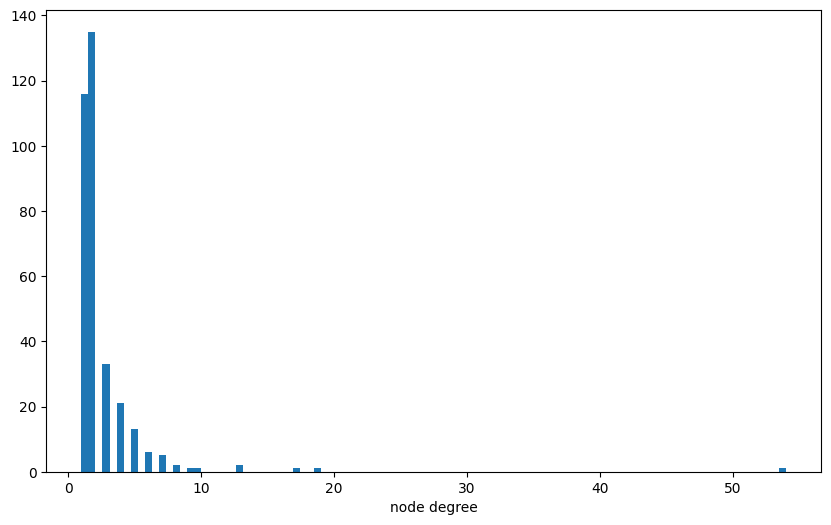

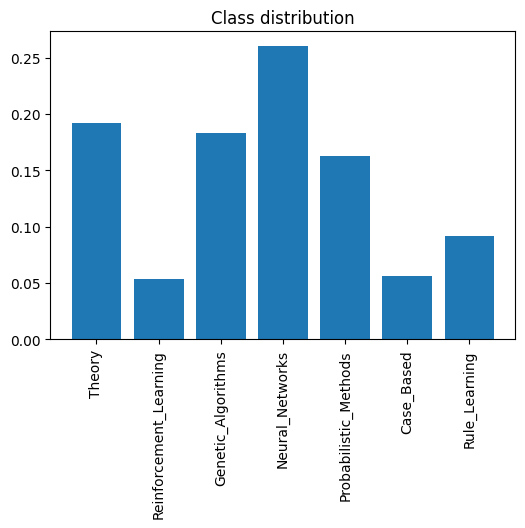

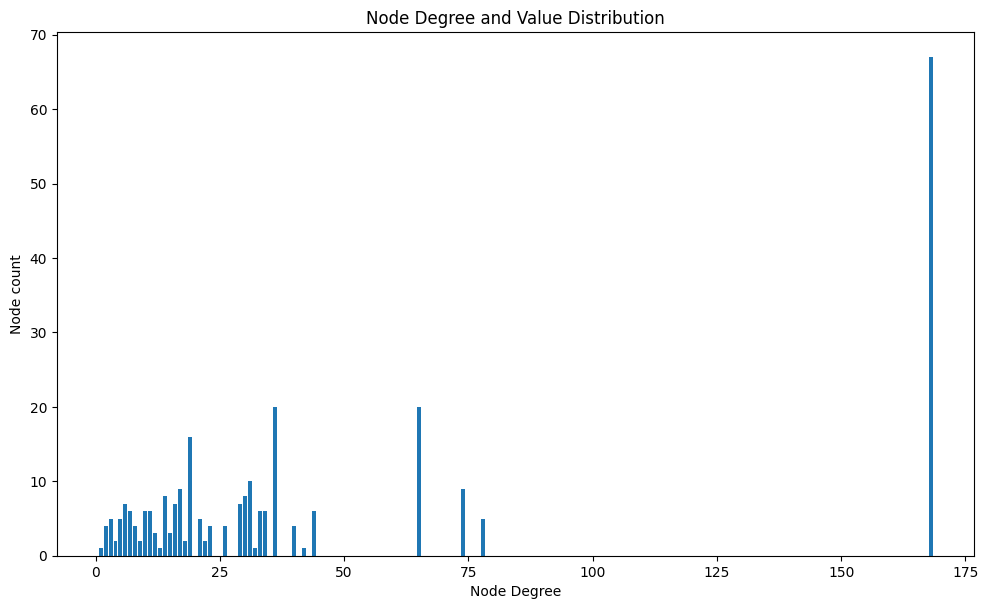

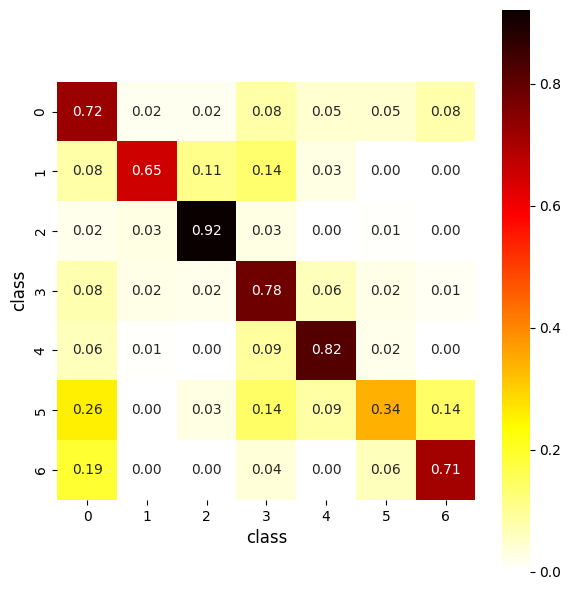

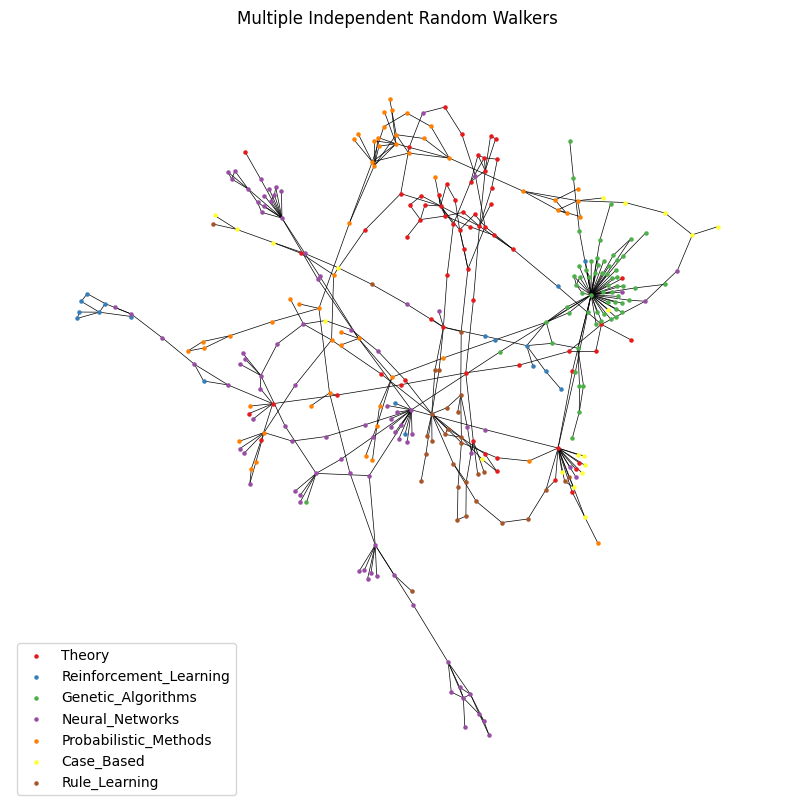

In [89]:
analyze_sampling(mirw_graph, "Multiple Independent Random Walkers", node_dist_dict)

###  Multi-Dimensional Random Walk (MDRW) or Frontier Sampling (FS)

It was born with the idea of alleviating one of the problems of sampling methods based on random walk: it is easy for exploration to get trapped in dense regions and not be able to escape. The algorithm works like this:
- Initialize a list $L=(v_0, v_1, \dots, v_l)$ with $l$ vertices according to some distribution. Initialize $V_S = E_S = \emptyset$;
- At each step, until termination, choose a node $v_i \in L$ with probability $p(v_i) \propto d_G(v_i)$ and:
  - sample a neighbor $v_j \in \mathcal{N}(v_i)$;
  - update $E_S = E_S \cup \{\{v_i, v_j\}\}$;
  - update $V_S = V_S \cup \{v_i\} \cup \{v_j\}$;
  - replace $v_j$ with $v_i$ in list $L$.

The procedure continues for a certain fixed number of iterations or until a certain fixed number of nodes has been explored. The subgraph $G_S=(V_E, E_S)$ will be composed of all the sampled edges and all the nodes $V_S$ incident to them.

In [90]:
def frontier_sampling(graph, num_samples,  num_random_walks, force):
 
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, num_random_walks, replace=False, p=probs)

  curr_degs = degs[node_samp_ids].numpy()
  L = torch.tensor(node_samp_ids)
  edges = []
  node_ids = np.array([], dtype=int)
  
  for n in node_samp_ids:
    node_ids = np.append(node_ids, n.item())
    
  node_dist_dict = {}
  n_it = 0

  while len(node_ids) < num_samples:
    n_it += 1

    curr_probs = curr_degs / np.sum(curr_degs)
    curr_id = np.random.choice(L, 1, replace=False, p=curr_probs)
    curr_id = curr_id.item()
    neighs, _, _, _  = k_hop_subgraph([curr_id],
                                      1,
                                      graph.edge_index)

    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] =  1
    else:
      node_dist_dict[curr_id] += 1

    mask = neighs != curr_id
    neighs = neighs[mask]
    neighs_deg = degs[neighs].numpy()
    neighs_probs = neighs_deg / np.sum(neighs_deg)
    new_id = np.random.choice(neighs, 1, replace=False, p = neighs_probs)
    new_id = new_id.item()
    new_pos = np.where(neighs == new_id)[0].item()
    
    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
    mask = L.eq(curr_id)
    L[mask] = new_id
    curr_degs[mask] = neighs_deg[new_pos].item()


  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", sample_edges.shape[1], " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")


  return sample_graph, node_dist_dict

In [91]:
num_samples_nodes, _ = num_samples(graph, 0.85)
fs_graph, node_dist_dict = frontier_sampling(graph, num_samples_nodes, 20, force=True)

922 iterations required to explore  406  different nodes


Number of nodes: 406
Number of edges: 1066
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.63
Number of classes: 7
Number of connected components: 3
Average clustering coefficient: 0.15731
Density: 0.00648
Transitivity: 0.05169


count  mean   std  min  25%  50%  75%   max
0  406.0  2.63  3.94  1.0  1.0  2.0  3.0  60.0

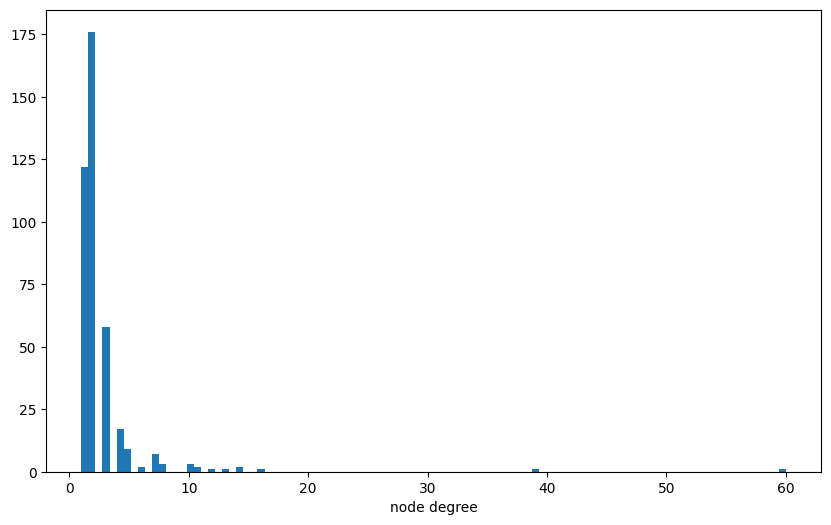

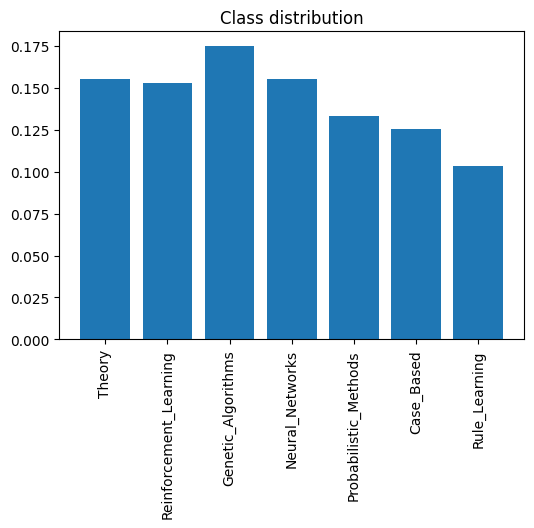

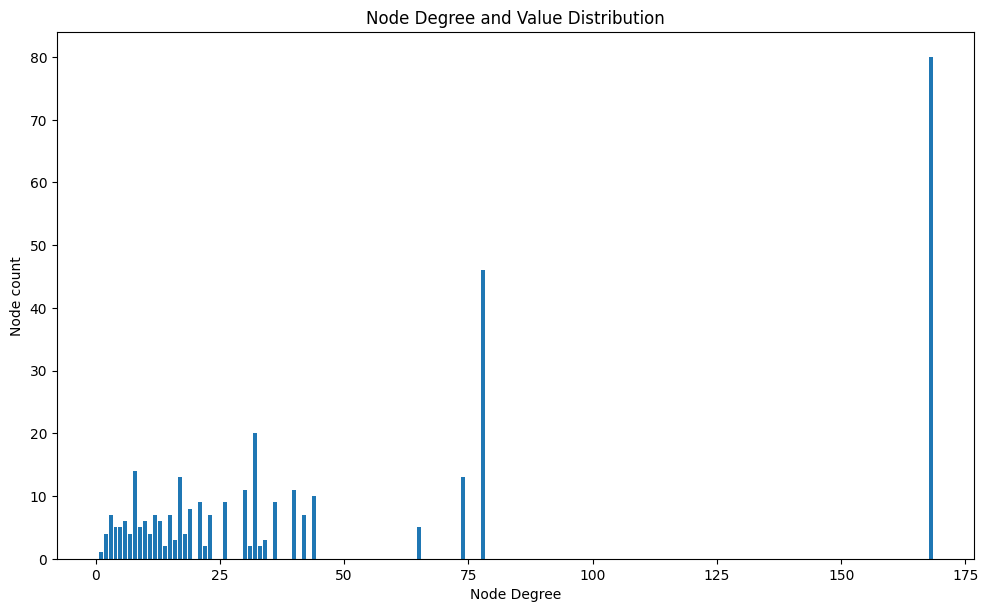

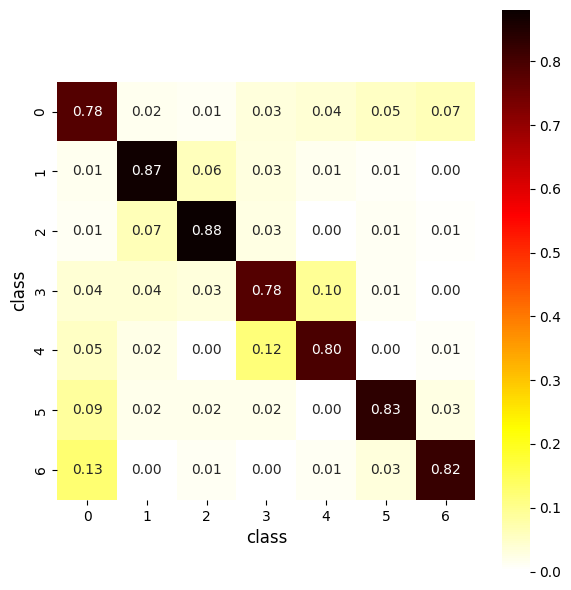

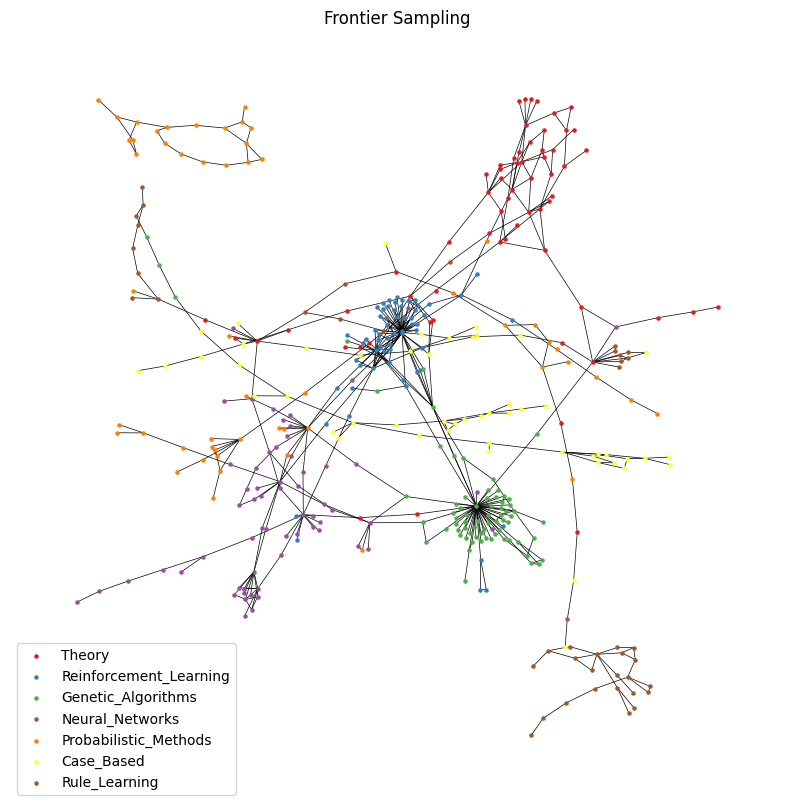

In [92]:
analyze_sampling(fs_graph, "Frontier Sampling", node_dist_dict)